In [1]:
import os
import json
import glob
import copy
import copy
import itertools
import pprint 
pp = pprint.PrettyPrinter(indent=4)

import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import statsmodels as sm
import cPickle as pkl

from scipy import stats as spstats

from pipeline.python.retinotopy import fit_2d_rfs as fitrf
from pipeline.python.retinotopy import convert_coords as coords

from pipeline.python.classifications import experiment_classes as util
#from pipeline.python.classifications import retino_structure as ret
from pipeline.python.classifications import aggregate_data_stats as aggr
from pipeline.python.classifications import rf_utils as rfutils

from pipeline.python.utils import natural_keys, label_figure, convert_range

from matplotlib.lines import Line2D




/home/julianarhee/Repositories/2p-pipeline/pipeline/python/retinotopy/fit_2d_rfs.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  Fi

In [2]:
%matplotlib notebook

# Set color schemes by visual area

In [3]:
# visual_areas = ['V1', 'Lm', 'Li']
# colors = ['k', 'royalblue', 'darkorange'] #sns.color_palette(palette='colorblind') #, n_colors=3)
# area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}
visual_areas = ['V1', 'Lm', 'Li']
colors = ['magenta', 'orange', 'dodgerblue'] #sns.color_palette(palette='colorblind') #, n_colors=3)
area_colors = {'V1': colors[0], 'Lm': colors[1], 'Li': colors[2]}

#### Plot params
pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

dpi = 150

# Set dataset parameters

In [4]:
#### Set trace ID and FOV/state type
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

#### Preprocessing params
responsive_test = None
responsive_thr = None
n_stds = None

#### RF fit params
response_type = 'dff'
fit_thr=0.5

#### Set outputdir for current analysis
fit_desc = fitrf.get_fit_desc(response_type=response_type)
outdir = os.path.join(aggregate_dir, 'receptive-fields', '%s__%s' % (traceid, fit_desc))
if not os.path.exists(outdir):
    os.makedirs(outdir)
print("... saving output to base dir:\n%s" % outdir)

#### Create data ID for labeling figures with data-types
#data_desc = '%s-%s' % (traceid, fit_desc)
data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])
print("DATA ID: %s" % data_id)

... saving output to base dir:
/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff
DATA ID: traces001|fit-2dgaus_dff-no-cutoff-thr-0.50


In [5]:


data_id = '|'.join([traceid, '%s-thr-%.2f' % (fit_desc, fit_thr)])


filter_by = 'drop_repeats'
data_id = '%s|%s' % (data_id, filter_by)
print(data_id)


traces001|fit-2dgaus_dff-no-cutoff-thr-0.50|drop_repeats


# Load data

In [6]:
# Get all data sets
sdata = aggr.get_aggregate_info(traceid=traceid, fov_type=fov_type, state=state)

In [7]:
#reload(rfutils)
#reload(fitrf)

In [68]:

scale_sigma = True
reliable_only = True


#### Get non-repeated FOV datasets
r_df, dkey_dict = rfutils.aggregate_rf_dataframes(filter_by, fit_thr=fit_thr,
                                                  traceid=traceid, fit_desc=fit_desc,
                                                  reliable_only=reliable_only,
                                                  #scale_sigma=scale_sigma, 
                                                  fov_type=fov_type, state=state, stimulus='rfs')

#### Make sure only 1 experiment type per dset
rdf_list=[]
for (visual_area, datakey), g in r_df.groupby(['visual_area', 'datakey']):
    expname = 'rfs' if visual_area=='V1' else 'rfs10'
    altname = 'rfs' if expname=='rfs10' else 'rfs10'
    if expname not in g['experiment'].values:
        vdf = g[g['experiment']==altname]
    else:
        vdf = g[g['experiment']==expname]
    rdf_list.append(vdf)
df = pd.concat(rdf_list)

#### Filter for good fits only
df = df[df['r2']>fit_thr]
df.groupby(['visual_area']).count()
    
#### Split fx, fy for theta comp
fx = abs(df[['std_x', 'std_y']].max(axis=1) * np.cos(df['theta']))
fy = abs(df[['std_x', 'std_y']].max(axis=1) * np.sin(df['theta']))

df['fx'] = fx
df['fy'] = fy



droppin repeats
Selecting 42 dsets
N dpaths: 48, N unfit: 0
N datasets included: 48, N sessions excluded: 4


In [9]:
# df.groupby(['visual_area', 'datakey']).count()
df.groupby(['visual_area', 'datakey']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  \
visual_area datakey                                                     
Li          20190502_JC076_fov1   19      19      19     19   19   19   
            20190522_JC089_fov1    6       6       6      6    6    6   
            20190527_JC092_fov2   14      14      14     14   14   14   
            20190527_JC092_fov3   42      42      42     42   42   42   
            20190528_JC092_fov1    7       7       7      7    7    7   
            20190605_JC090_fov1   17      17      17     17   17   17   
            20190607_JC091_fov1   69      69      69     69   69   69   
            20190612_JC099_fov1   40      40      40     40   40   40   
            20190614_JC091_fov1   99      99      99     99   99   99   
            20190617_JC099_fov1   11      11      11     11   11   11   
            20191003_JC111_fov1   11      11      11     11   11   11   
            20191007_JC091_fov1   21      21      21     21   21   21   
            20191008_JC091_fov1   46      46      46     46   46   46   
            20191018_JC113_fov1   13      13      13     13   13   13   
            20191105_JC117_fov1   10      10      10     10   10   10   
            20191111_JC120_fov1    4       4       4      4    4    4   
Lm          20190423_JC076_fov1   15      15      15     15   15   15   
            20190509_JC078_fov1   15      15      15     15   15   15   
            20190513_JC078_fov1   19      19      19     19   19   19   
            20190517_JC083_fov1   23      23      23     23   23   23   
            20190525_JC084_fov1   38      38      38     38   38   38   
            20190602_JC080_fov2   34      34      34     34   34   34   
            20190603_JC080_fov1   57      57      57     57   57   57   
            20190618_JC097_fov1   28      28      28     28   28   28   
            20190627_JC091_fov1    9       9       9      9    9    9   
            20191004_JC110_fov3   11      11      11     11   11   11   
            20191004_JC110_fov4   19      19      19     19   19   19   
            20191012_JC113_fov3   18      18      18     18   18   18   
            20191104_JC117_fov2   50      50      50     50   50   50   
            20191106_JC120_fov4    8       8       8      8    8    8   
            20191111_JC117_fov2    2       2       2      2    2    2   
V1          20190420_JC076_fov1   36      36      36     36   36   36   
            20190511_JC083_fov1   44      44      44     44   44   44   
            20190522_JC084_fov1  130     130     130    130  130  130   
            20190613_JC097_fov1   67      67      67     67   67   67   
            20190616_JC097_fov1  102     102     102    102  102  102   
            20190617_JC097_fov1   89      89      89     89   89   89   
            20190622_JC085_fov1   27      27      27     27   27   27   
            20191006_JC110_fov1   48      48      48     48   48   48   
            20191106_JC120_fov3   66      66      66     66   66   66   
            20191111_JC117_fov1   21      21      21     21   21   21   

                                 animalid  cell  experiment  fovnum  session  \
visual_area datakey                                                            
Li          20190502_JC076_fov1        19    19          19      19       19   
            20190522_JC089_fov1         6     6           6       6        6   
            20190527_JC092_fov2        14    14          14      14       14   
            20190527_JC092_fov3        42    42          42      42       42   
            20190528_JC092_fov1         7     7           7       7        7   
            20190605_JC090_fov1        17    17          17      17       17   
            20190607_JC091_fov1        69    69          69      69       69   
            20190612_JC099_fov1        40    40          40      40       40   
            20190614_JC091_fov1        99    99          99      99       99   
            20

In [10]:
df.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           429     429     429    429  429  429       429   429      429   
Lm           346     346     346    346  346  346       346   346      346   
V1           630     630     630    630  630  630       630   630      630   

             experiment  fovnum  session  std_x  std_y  fwhm_avg  std_avg  \
visual_area                                                                 
Li                  429     429      429    429    429       429      429   
Lm                  346     346      346    346    346       346      346   
V1                  630     630      630    630    630       630      630   

             area  datakey_ix   fx   fy  
visual_area                              
Li            429         429  429  429  
Lm            346         346  346  346  
V1            630         630  630  630

# Set output dir

In [11]:
genstats_dir = os.path.join(outdir, 'general-stats', '%s_2' %filter_by)
if not os.path.exists(genstats_dir):
    os.makedirs(genstats_dir)
print(genstats_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2


## Check size of RFs by x/y

In [12]:
# fx = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.cos(df['theta']))
# fy = abs(df[['sigma_x', 'sigma_y']].max(axis=1)*0.5 * np.sin(df['theta']))

# df['fx'] = fx
# df['fy'] = fy

# 0 degrees is horizontal, where M>m
# 90 degrees, spans more along vertical axis
# 

In [13]:
df.head()

r2     fwhm_x     fwhm_y     theta         x0         y0 animalid  \
0  0.826039  23.640365  13.125770  0.117896   6.700889  -8.282818    JC076   
1  0.725070  43.796452  29.207447  0.234407 -22.165338  -2.970096    JC076   
2  0.701576  47.503138  24.790225  0.458457  15.301437  31.251545    JC076   
3  0.781400  23.130716  44.809417  0.155088   2.496442  37.699467    JC076   
4  0.627347  32.132070  25.065036  5.892774   0.014677  17.244112    JC076   

   cell              datakey experiment    ...      session visual_area  \
0     0  20190502_JC076_fov1        rfs    ...     20190502          Li   
1    84  20190502_JC076_fov1        rfs    ...     20190502          Li   
2   115  20190502_JC076_fov1        rfs    ...     20190502          Li   
3   120  20190502_JC076_fov1        rfs    ...     20190502          Li   
4   135  20190502_JC076_fov1        rfs    ...     20190502          Li   

       std_x      std_y   fwhm_avg    std_avg        area  datakey_ix  \
0  10.059730   5.585434  18.383068   7.822582  176.519678           0   
1  18.636788  12.428701  36.501949  15.532744  727.690433           0   
2  20.214101  10.549032  36.146682  15.381567  669.910720           0   
3   9.842858  19.067837  33.970067  14.455348  589.620427           0   
4  13.673221  10.665973  28.598553  12.169597  458.164233           0   

          fx        fy  
0   9.989899  1.183253  
1  18.127112  4.328703  
2  18.126724  8.946049  
3  18.838985  2.945347  
4  12.644344  5.203608  

[5 rows x 21 columns]

In [26]:
df.groupby(['visual_area']).mean()['std_avg']

visual_area
Li    13.103955
Lm    10.395978
V1     9.339963
Name: std_avg, dtype: float64

In [27]:
df.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           429     429     429    429  429  429       429   429      429   
Lm           346     346     346    346  346  346       346   346      346   
V1           630     630     630    630  630  630       630   630      630   

             experiment  fovnum  session  std_x  std_y  fwhm_avg  std_avg  \
visual_area                                                                 
Li                  429     429      429    429    429       429      429   
Lm                  346     346      346    346    346       346      346   
V1                  630     630      630    630    630       630      630   

             area  datakey_ix   fx   fy  
visual_area                              
Li            429         429  429  429  
Lm            346         346  346  346  
V1            630         630  630  630

In [17]:
df.groupby(['visual_area','experiment']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  \
visual_area experiment                                                         
Li          rfs          19      19      19     19   19   19        19    19   
            rfs10       410     410     410    410  410  410       410   410   
Lm          rfs         176     176     176    176  176  176       176   176   
            rfs10       170     170     170    170  170  170       170   170   
V1          rfs         543     543     543    543  543  543       543   543   
            rfs10        87      87      87     87   87   87        87    87   

                        datakey  fovnum  session  std_x  std_y  fwhm_avg  \
visual_area experiment                                                     
Li          rfs              19      19       19     19     19        19   
            rfs10           410     410      410    410    410       410   
Lm          rfs             176     176      176    176    176       176   
            rfs10           170     170      170    170    170       170   
V1          rfs             543     543      543    543    543       543   
            rfs10            87      87       87     87     87        87   

                        std_avg  area  datakey_ix   fx   fy  
visual_area experiment                                       
Li          rfs              19    19          19   19   19  
            rfs10           410   410         410  410  410  
Lm          rfs             176   176         176  176  176  
            rfs10           170   170         170  170  170  
V1          rfs             543   543         543  543  543  
            rfs10            87    87          87   87   87

#### Get x + y components of vector spanned by ellipse (major)

In [19]:
datakey = '20190622_JC085_fov1'
rid=25

#params=['r2', 'sigma_x', 'sigma_y', 'theta', 'x0', 'y0', 'datakey', 'cell', 'experiment', 'avg_size', 'fx', 'fy']
#df[(df['datakey']==datakey) & (df['cell']==rid)][params]

90


<IPython.core.display.Javascript object>


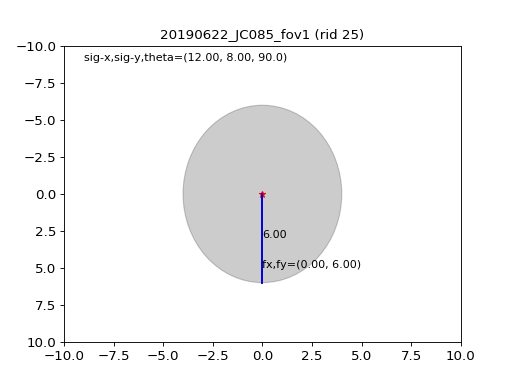

(0.0, 6.0)


In [20]:
from matplotlib.patches import Ellipse
# 0 degrees is horizontal, where M>m
# 90 degrees, spans more along vertical axis


x0, y0 = (0, 0)
M = 12 #10
m = 8 #3
theta = 90 #np.rad2deg(4.15)
print(theta)
angle = np.deg2rad(theta)

fig, ax = pl.subplots() #pl.figure()
ax.plot(x0, y0, 'r*')

el = Ellipse((x0, y0), width=M, height=m, angle=theta, alpha=0.2, color='k')
ax.add_artist(el)


ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])

F = M/2.

xe = F * np.cos(np.deg2rad(theta))
ye = F * np.sin(np.deg2rad(theta))
ax.plot([x0, xe], [y0, ye], 'k')
ax.text(xe/2., ye/2., '%.2f' % F)

fx = round(F * np.cos(np.deg2rad(theta)), 2)
fy = round(F * np.sin(np.deg2rad(theta)), 2)
print(fx, fy)

ax.text(0, 5, 'fx,fy=(%.2f, %.2f)' % (fx, fy))
ax.text(-9, -9, 'sig-x,sig-y,theta=(%.2f, %.2f, %.1f)' % (M, m, theta))
ax.plot([x0, fx], [y0, y0], 'r')
ax.plot([x0, x0], [y0, fy], 'b')


ax.set_title('%s (rid %i)' % (datakey, rid))

ax.invert_yaxis()

## Plot x- and y-components of fit RFs

In [21]:
print(scale_sigma)

True


<IPython.core.display.Javascript object>


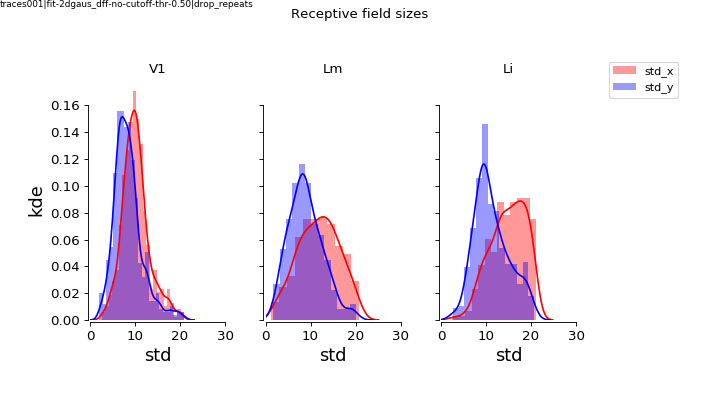

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2', 'split_std_xy_std_drop_repeats')


In [23]:
split_components = False
scale_sigma = False
curr_metric = 'std'

xlim = 25 if curr_metric=='std' else 60.

x_color = 'r'
y_color = 'b'
#experiment = 'rfs'

#_df = df[df['experiment']==experiment].copy()

#sigma_str = 'fwhm' if scale_sigma else 'sigma'
if split_components:
    xlim=35
else:
    xlim = 60 if scale_sigma else 30
sz_metric = 'f' if split_components else '%s_' % curr_metric

offset=0
fig, axes = pl.subplots(1,3, figsize=(9,5), sharey=True, sharex=True)

for ax, visual_area in zip(axes.flat, visual_areas):
    g = df[df['visual_area']==visual_area].copy()
    
    sns.distplot(g['%sx' % sz_metric], color=x_color, ax=ax, label='%sx' % sz_metric)
    sns.distplot(g['%sy' % sz_metric], color=y_color, ax=ax, label='%sy' % sz_metric)
    ax.set_title(visual_area)
    
    ax.set_xlim([0, xlim])

    ax.set_xlabel(curr_metric)


sns.despine(trim=True, offset=2)
    
pl.subplots_adjust(wspace=0.3, right=0.8, top=0.8, bottom=0.2)
axes[0].set_ylabel('kde')
axes[2].legend(bbox_to_anchor=(1.8, 1.1))

label_figure(fig, data_id)
fig.suptitle('Receptive field sizes')

figname = 'split_%sxy_%s_%s' % (sz_metric, curr_metric, filter_by)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(genstats_dir, figname)

In [24]:
fieldnames = ['x0', 'y0', 'theta', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(fieldnames)

['x0', 'y0', 'theta', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


<IPython.core.display.Javascript object>


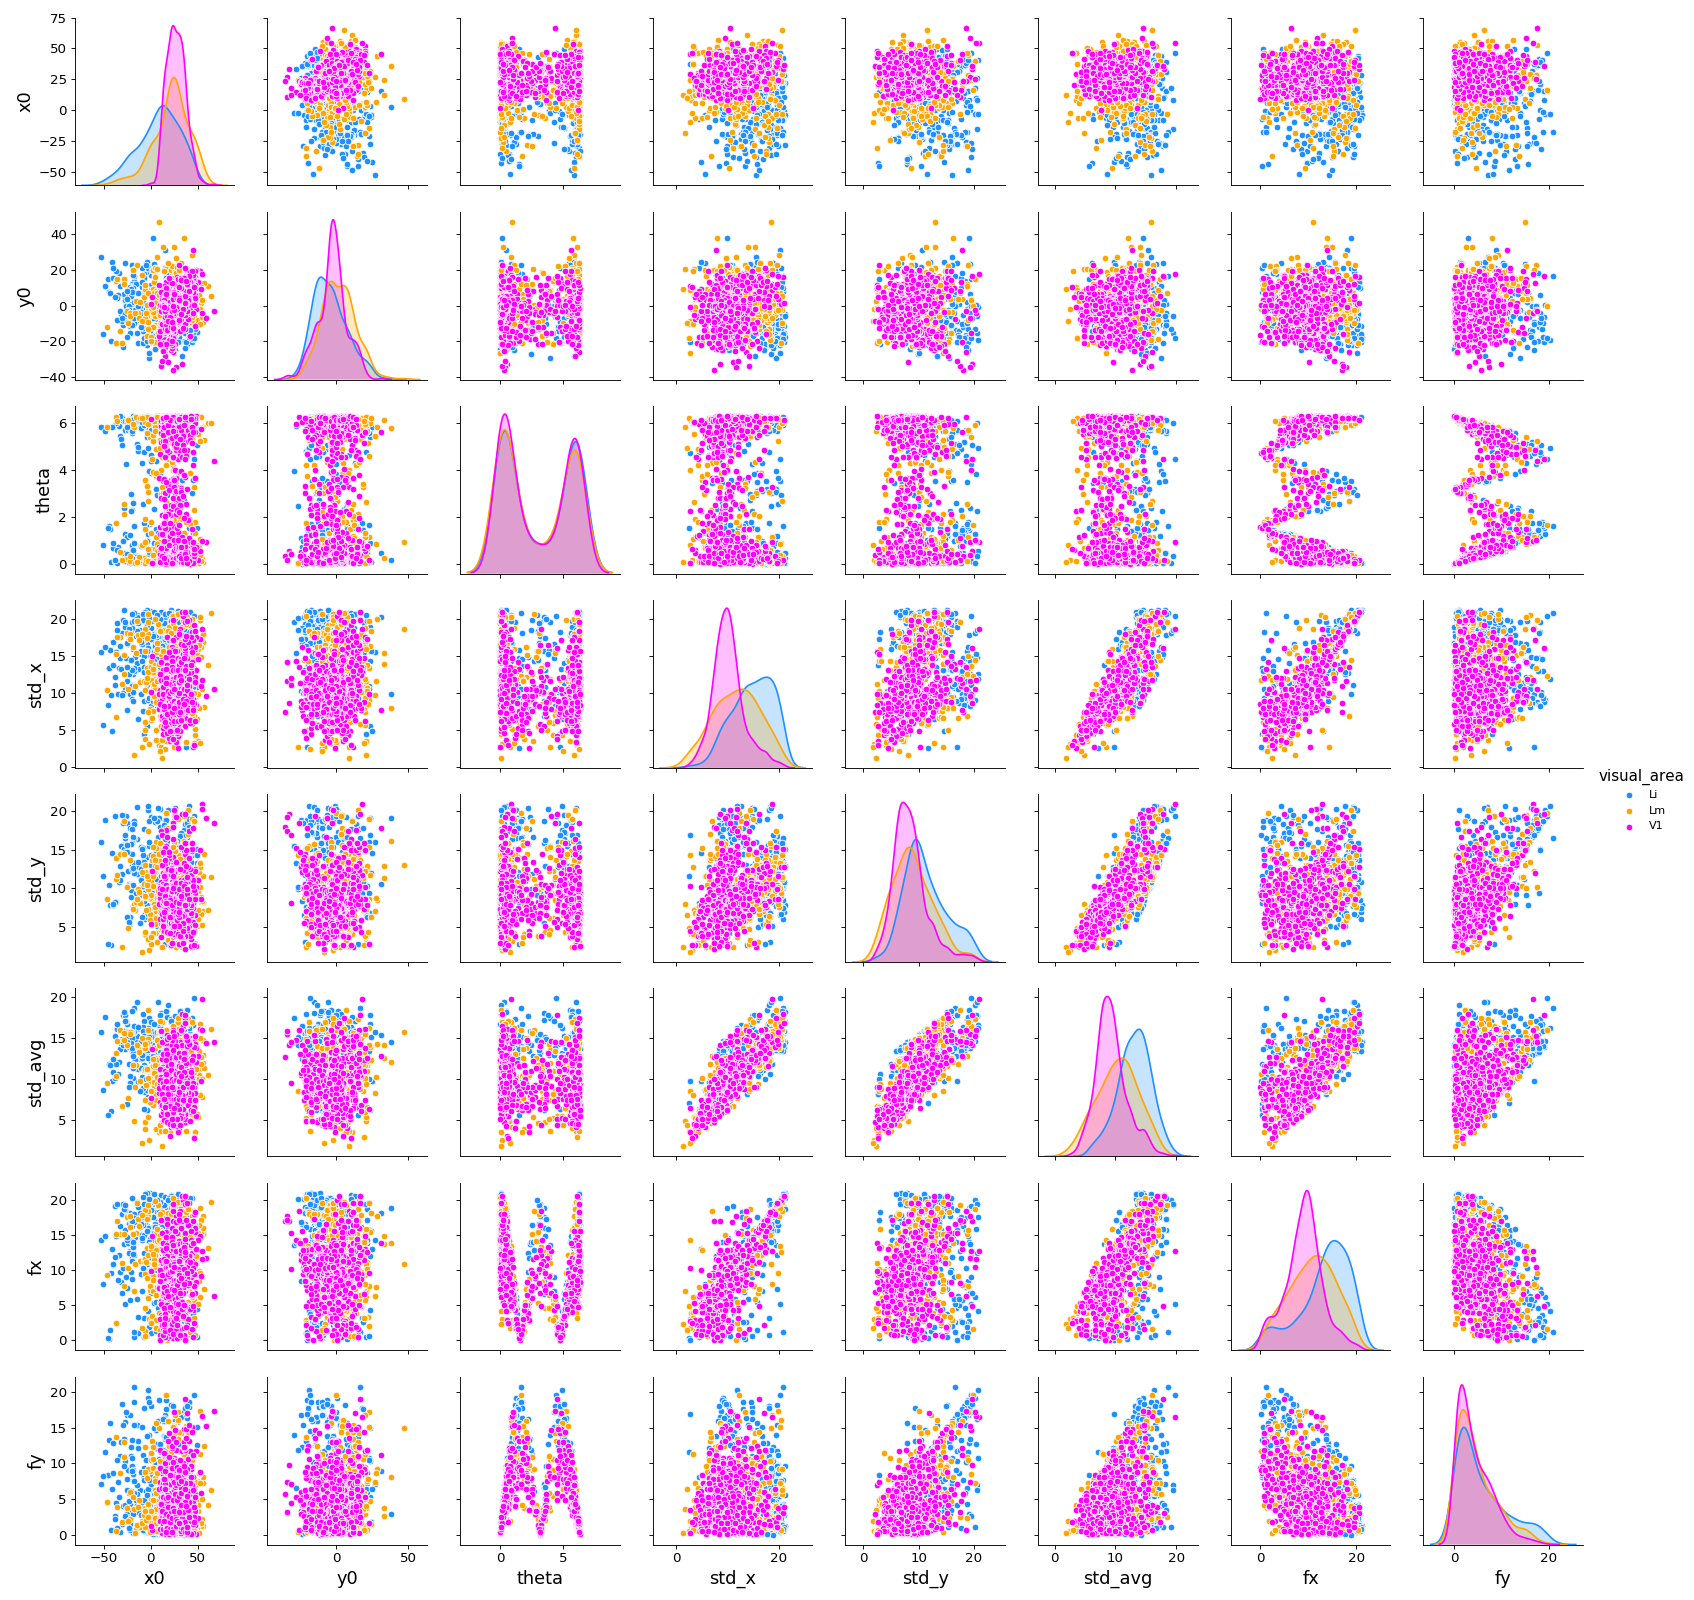

In [25]:
# theta = 90 is vertically-long, 0 = horizontal

sns.pairplot(df[fieldnames], hue='visual_area', palette=area_colors)
pl.savefig(os.path.join(genstats_dir, 'pairplot_all_params_%s_%s.png' % (curr_metric, filter_by)))


## Check out thetas

<IPython.core.display.Javascript object>


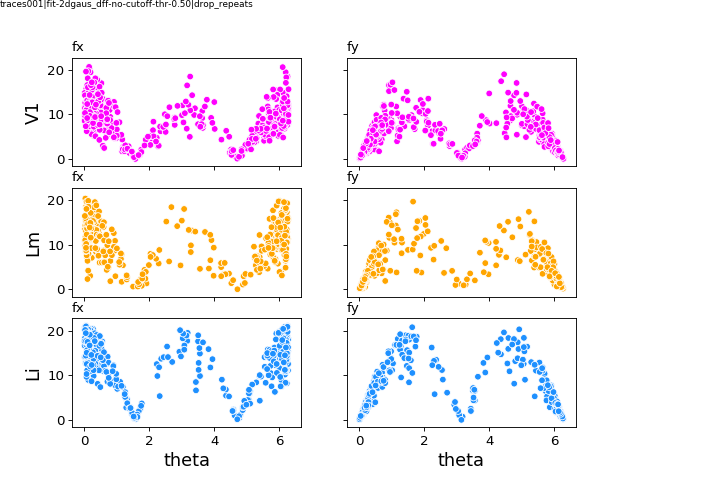

In [28]:
fig, axn = pl.subplots(3,2,figsize=(9,6), sharex=True, sharey=True)
for ri, visual_area in enumerate(visual_areas):
    g = df[df['visual_area']==visual_area]
    ax = axn[ri, 0]
    sns.scatterplot(x='theta', y='fx', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    ax.set_ylabel(visual_area)
    ax.set_title('fx', loc='left')
    
    ax = axn[ri, 1]
    sns.scatterplot(x='theta', y='fy', hue='visual_area', palette=area_colors, data=g, ax=ax, legend=0)
    #pl.legend(bbox_to_anchor=(1.1,1))
    ax.set_title('fy', loc='left')
pl.subplots_adjust(wspace=0.2, right=0.8, left=0.1)
label_figure(fig, data_id)

pl.savefig(os.path.join(genstats_dir, 'fx_fy_by_theta_%s.svg' % filter_by))

In [ ]:
# def annotateBars(row, ax=ax, fontsize=12): 
#     for p in ax.patches:
#         ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., 0.), #p.get_height()),
#                     ha='center', va='center', fontsize=fontsize, color='k', 
#                     rotation=0, xytext=(0, 20),
#              textcoords='offset points')
        
    

In [ ]:
# def compare_single_metric(comdf, curr_metric='avg_size', ax=None, marker='o'):

#     offset = 0.25
    
#     if ax is None:
#         fig, ax = pl.subplots(figsize=(5,4), dpi=dpi)
#         fig.patch.set_alpha(0)
#         ax.patch.set_alpha(0)
    
#     # Plot paired values
#     aix=0
#     for ai, visual_area in enumerate(visual_areas):

#         plotdf = comdf[comdf['visual_area']==visual_area]
#         a_vals = plotdf[plotdf['experiment']=='rfs'].sort_values(by='datakey')[curr_metric].values
#         b_vals = plotdf[plotdf['experiment']=='rfs10'].sort_values(by='datakey')[curr_metric].values

#         by_exp = [(a, e) for a, e in zip(a_vals, b_vals)]
#         for pi, p in enumerate(by_exp):
#             ax.plot([aix-offset, aix+offset], p, marker=marker, color=area_colors[visual_area], 
#                     alpha=1, lw=0.5,  zorder=0)
#         aix = aix+1

#     # Plot average
#     sns.barplot("visual_area", curr_metric, data=comdf, 
#                 hue='experiment', #zorder=0,
#                 ax=ax, order=visual_areas,
#                 errcolor="k", edgecolor=('k', 'k', 'k'), facecolor=(1,1,1,0), linewidth=2.5)
#     ax.legend_.remove()

#     set_split_xlabels(ax, a_label='rfs', b_label='rfs10')
    
    return ax


In [29]:
reload(rfutils)

<module 'pipeline.python.classifications.rf_utils' from '/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/rf_utils.pyc'>

In [30]:
curr_metric = 'std'
params = ['x0', 'y0', 'theta', '%s_x' % curr_metric, '%s_y' % curr_metric, 
              '%s_avg' % curr_metric, 'fx', 'fy', 'visual_area']
print(params)

['x0', 'y0', 'theta', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']


# Visualize general stats

### 1. Average RF size

<IPython.core.display.Javascript object>


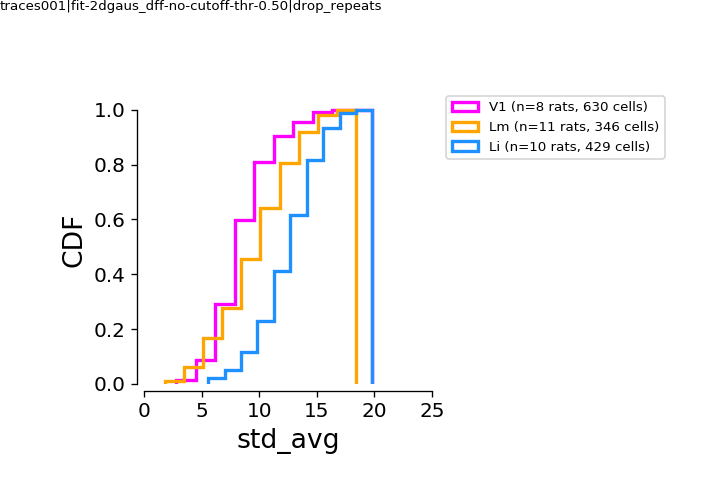

std_avg_drop_repeats_cdf


In [31]:
curr_metric = 'std_avg'
cdf = True
plot_type = 'cdf' if cdf else 'hist'
max_size = 50 if scale_sigma else 30
#for experiment, expdf in rfdf.groupby(['experiment']):

fig, ax = pl.subplots(figsize=(6,4), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax = rfutils.compare_rf_size(df, metric=curr_metric, cdf=cdf, ax=ax, alpha=1)
ax.set_xlim([0, 25])
sns.despine(ax=ax, trim=True, offset=4)

pl.subplots_adjust(right=0.6, top=0.8, bottom=0.2, left=0.2)

label_figure(fig, '%s' % (data_id))
figname = '%s_%s_%s' % (curr_metric, filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s.svg' % figname))
print(figname)

In [123]:
mean_sizes

visual_area              datakey    std_avg
0           Li  20190522_JC089_fov1  14.125163
1           Li  20190527_JC092_fov2  13.457365
2           Li  20190527_JC092_fov3  12.267896
3           Li  20190528_JC092_fov1  13.582320
4           Li  20190605_JC090_fov1  14.165804
5           Li  20190607_JC091_fov1  13.119728
6           Li  20190612_JC099_fov1  13.479894
7           Li  20190614_JC091_fov1  13.062281
8           Li  20190617_JC099_fov1  12.532571
9           Li  20191003_JC111_fov1  13.113333
10          Li  20191007_JC091_fov1  13.662070
11          Li  20191008_JC091_fov1  13.342374
12          Li  20191018_JC113_fov1  12.789248
13          Li  20191105_JC117_fov1  13.688065
14          Li  20191111_JC120_fov1  12.486939
15          Lm  20190602_JC080_fov2  11.158928
16          Lm  20190618_JC097_fov1  10.454305
17          Lm  20191004_JC110_fov3  12.591393
18          Lm  20191004_JC110_fov4  11.520776
19          Lm  20191012_JC113_fov3  12.342155
20          Lm  20191104_JC117_fov2  10.005941
21          Lm  20191106_JC120_fov4  13.410509
22          Lm  20191111_JC117_fov2  12.358567
23          V1  20190420_JC076_fov1   9.108206
24          V1  20190511_JC083_fov1   8.588291
25          V1  20190522_JC084_fov1  10.141840
26          V1  20190613_JC097_fov1   9.244314
27          V1  20190616_JC097_fov1   7.891846
28          V1  20190617_JC097_fov1   8.168665
29          V1  20190622_JC085_fov1  10.162788
30          V1  20191006_JC110_fov1   8.788104

## 2. Bar plot for fov averages

<IPython.core.display.Javascript object>


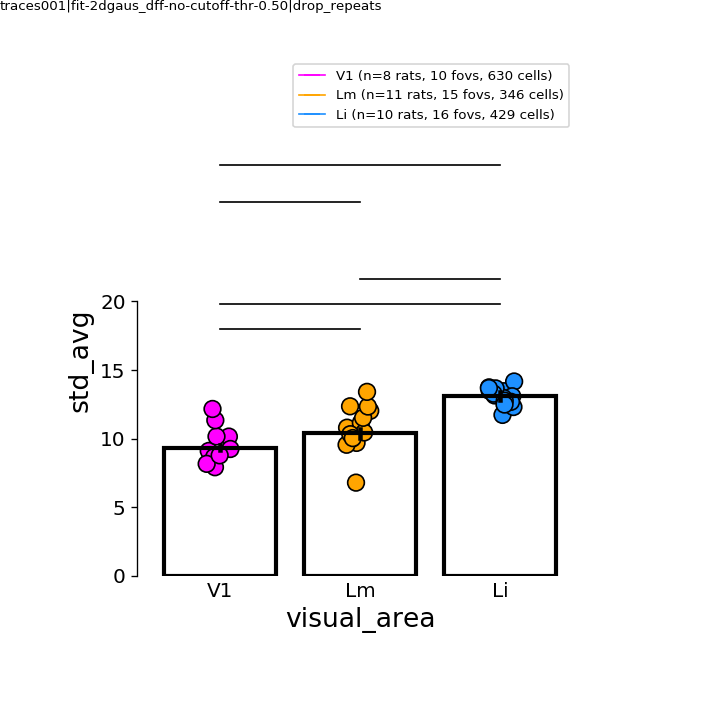

********* std_avg **********
[('V1', 'Lm')] Statistics=84861.000, p=0.000, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=42668.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=40023.000, p=0.000, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 5.0959756171948328e-09), (('V1', 'Li'), True, 1.0760841785419654e-79), (('Lm', 'Li'), True, 2.5438615881114449e-28)]
18.0
****************************
std_avg_groupby-datakey_mean-fov_drop_repeats__multicomp-holm_ci


In [33]:
curr_metric = 'std_avg'
multi_comp_test = 'holm'
mean_metric = 'mean'
groupby = 'datakey'

# for experiment, expdf in rfdf.groupby(['experiment']):

# Average RF sizes for each FOV
if groupby is not None:
    grped = df.groupby(['visual_area', groupby])
    group_str = 'groupby-%s' % groupby
else:
    grped = df.groupby(['visual_area'])
    group_str = ''


if mean_metric == 'median':
    mean_sizes = grped.median()[curr_metric].reset_index()
else:
    mean_sizes = grped.mean()[curr_metric].reset_index()

fig, ax = pl.subplots(figsize=(6,6), dpi=dpi)
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

sns.barplot(x="visual_area", y=curr_metric, data=df, 
            ax=ax, order=visual_areas, ci=95,
            errcolor="k", edgecolor=('k', 'k', 'k'), 
            facecolor=(1,1,1,0), linewidth=2.5)

sns.stripplot(x='visual_area', y=curr_metric, data=mean_sizes, 
              zorder=0,
              ax=ax, #hue='cond',
              s=10, palette=area_colors, 
              order=visual_areas, 
              color=(1,1,1,0), 
              dodge=True,
              #facecolor=(1,1,1,0),
              edgecolor='k',
              marker='o',linewidth=1)

print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(df, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax)
print("****************************")

#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True)
ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df, area_colors=area_colors, markersize=10, marker='_')
ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)


label_figure(fig, data_id)
figname = '%s_%s_%s-fov_%s__multicomp-%s_ci' % (curr_metric, group_str, mean_metric, filter_by, multi_comp_test)
pl.savefig(os.path.join(genstats_dir, '%s_3.svg' % figname))
print(figname)

#### Stats by fov (maen of means)

In [36]:

print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(mean_sizes, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
#annotate_stats_areas(statresults, ax)
print("****************************")

********* std_avg **********
[('V1', 'Lm')] Statistics=38.000, p=0.021, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=1.000, p=0.000, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=14.000, p=0.000, ... Different distribution (reject H0)
[(('V1', 'Lm'), True, 0.021451364408290676), (('V1', 'Li'), True, 4.563911709568188e-05), (('Lm', 'Li'), True, 4.563911709568188e-05)]
****************************


## Distn of all rf sizes

<IPython.core.display.Javascript object>


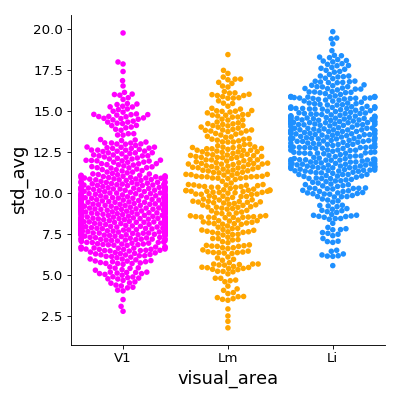

std_avg_distns_drop_repeats


In [37]:
curr_metric = 'std_avg'
plot_kind = 'swarm'

fg = sns.catplot(x="visual_area", y=curr_metric, data=df,# col='experiment',
           palette=area_colors, order=visual_areas, kind=plot_kind, dodge=True, 
                 edgecolor='w', linewidth=0, alpha=1)

figname = '%s_distns_%s' % (curr_metric, filter_by)
fg.fig.savefig(os.path.join(genstats_dir, '%s_3.svg' % figname))
print(figname)

## Look at N cells fit 

In [38]:
countdf = df.groupby([ 'visual_area', 'animalid', 'datakey']).count()['cell'].reset_index()
countdf.rename(columns={'cell': 'n_cells'}, inplace=True)


<IPython.core.display.Javascript object>


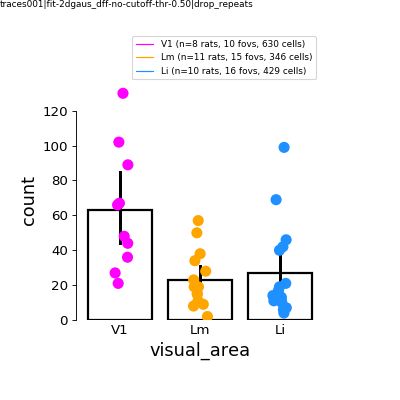

********* n_cells **********
[('V1', 'Lm')] Statistics=18.000, p=0.001, ... Different distribution (reject H0)
[('V1', 'Li')] Statistics=25.500, p=0.002, ... Different distribution (reject H0)
[('Lm', 'Li')] Statistics=113.000, p=0.399, ... Same distribution (fail to reject H0)
[(('V1', 'Lm'), True, 0.0025755084748453178), (('V1', 'Li'), True, 0.0044130118159071575), (('Lm', 'Li'), False, 0.39852435605267511)]
27.24
****************************
('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2', 'n_cells_avg-fov_drop_repeats__multicomp-holm')


In [39]:
curr_metric = 'n_cells'
fg = sns.catplot(x="visual_area", y=curr_metric, data=countdf, #hue="experiment", 
               kind = 'bar',
                errcolor="k", edgecolor=('k', 'k', 'k'), order=visual_areas,
                facecolor=(1,1,1,0), linewidth=2, zorder=0, legend=0) #, ax=ax)
sns.stripplot(x='visual_area', y=curr_metric, data=countdf, #hue='experiment',
             order=visual_areas, ax=fg.ax, palette=area_colors, dodge=True,
             size=10)
fg.ax.tick_params(axis='x', size=0)
fg.ax.set_ylabel('count')


#ax.set_ylim([-1, 40])
pl.subplots_adjust(top=0.8, bottom=0.2, left=0.2, right=0.8)
sns.despine(offset=4, trim=True, bottom=True, ax=fg.ax)
fg.ax.tick_params(axis='x', size=0)

# Get counts of samples for legend
legend_elements = aggr.get_counts_for_legend(df, area_colors=area_colors, markersize=10, marker='_')
fg.ax.legend(handles=legend_elements, bbox_to_anchor=(1,1.2), fontsize=8)



print("********* %s **********" % (curr_metric))
statresults = aggr.do_mannwhitney(countdf, metric=curr_metric, multi_comp_test=multi_comp_test)
print(statresults)
# stats significance
aggr.annotate_stats_areas(statresults, ax, lw=1, color='k', 
                         visual_areas=['V1', 'Lm', 'Li'])
   
print("****************************")

    
#fg.ax.set_title('N cells with good fits(within 95% CI)', loc='left')
label_figure(fg.fig, data_id)

figname = '%s_avg-fov_%s__multicomp-%s' % (curr_metric, filter_by, multi_comp_test)
fg.fig.savefig(os.path.join(genstats_dir, '%s_2.svg' % figname))

print(genstats_dir, figname)


## All fit params

In [40]:
params

['x0', 'y0', 'theta', 'std_x', 'std_y', 'std_avg', 'fx', 'fy', 'visual_area']

<IPython.core.display.Javascript object>


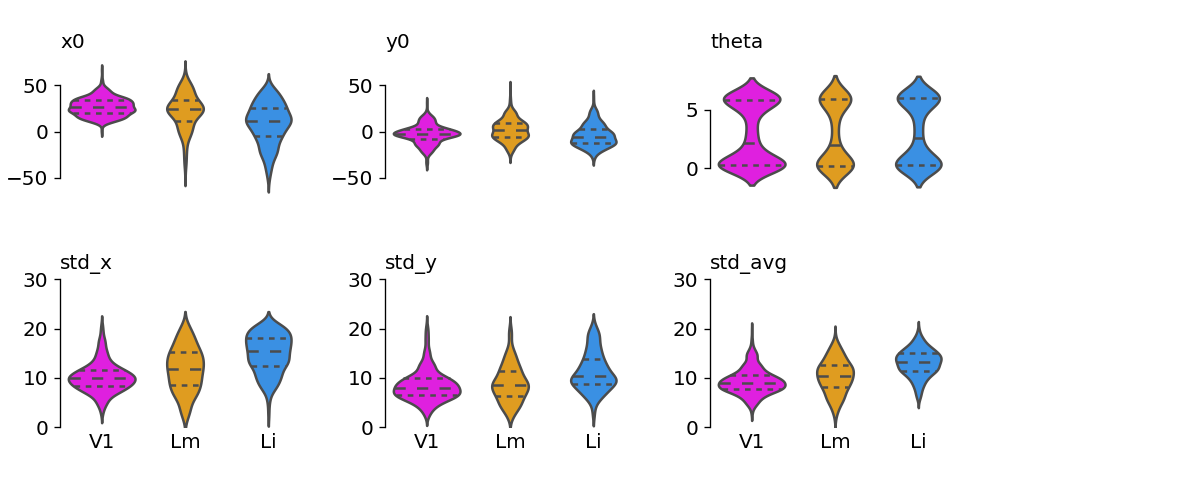

('/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/general-stats/drop_repeats_2', 'all-metrics_drop_repeats_violin')


In [46]:
plot_type = 'violin'

fig, axes = pl.subplots(2, 3, figsize=(10,4), dpi=dpi)
fig.patch.set_alpha(0)

for ai, (ax, param) in enumerate(zip(axes.flat, params)):
    if plot_type=='violin':
        sns.violinplot(x='visual_area', y=param, data=df, ax=ax,
                      palette=area_colors, order=visual_areas,
                       scale='count', inner='quartile')
    else:
        sns.swarmplot(x='visual_area', y=param, data=df, ax=ax,
                      palette=area_colors, dodge=True, order=visual_areas)
    if ai<3:
        ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', size=0)

    ax.set_ylabel('')
    ax.set_title(param, fontsize=12, loc='left')
    
    if param=='theta':
        ax.set_ylim([-np.pi, 3*np.pi])
    elif param in ['x0','y0']:
        ax.set_ylim([-80, 80])
    elif 'fwhm' in param:
        ax.set_ylim([0, 60])
    elif 'std' in param:
        ax.set_ylim([0, 30])
    sns.despine(trim=True, ax=ax, bottom=True)
    
pl.subplots_adjust(wspace=0.3, hspace=0.5, right=0.8, left=0.05)


# Save
figname = 'all-metrics_%s_%s' % (filter_by, plot_type)
pl.savefig(os.path.join(genstats_dir, '%s_3.svg' % figname))

print(genstats_dir, figname)    

# Compare cortical position vs. VF position

In [47]:
def get_fov_coordinates(animalid, session, fov, rffits):

    S = util.Session(animalid, session, fov)
    experiment_list = S.get_experiment_list()
    if 'rfs10' in experiment_list:
        S.get_experiment_data(experiment='rfs10')
        rf_exp_name = 'rfs10'
    else:
        S.get_experiment_data(experiment='rfs')
        rf_exp_name= 'rfs'
    
    masks, zimg = S.load_masks()
    roi_contours = coords.contours_from_masks(masks)
    # Convert to brain coords
    fov_pos_x, rf_xpos, xlim, fov_pos_y, rf_ypos, ylim = coords.get_roi_position_um(rffits, roi_contours, 
                                                                         rf_exp_name=rf_exp_name,
                                                                         convert_um=True)
    
    posdf = pd.DataFrame({'xpos_fov': fov_pos_y,
                          'xpos_rf': rf_xpos,
                          'ypos_fov': fov_pos_x,
                          'ypos_rf': rf_ypos,
                         'visual_area': [visual_area for _ in range(len(fov_pos_x))],
                         'animalid': [animalid for _ in range(len(fov_pos_x))],
                         'session': [session for _ in range(len(fov_pos_x))],
                         'fov': [fov for _ in range(len(fov_pos_x))]})
    return posdf


#### Create output subdir

In [48]:
scatter_dir = os.path.join(outdir, 'scatter', '%s_2' %filter_by)
if not os.path.exists(scatter_dir):
    os.makedirs(scatter_dir)
print(scatter_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/receptive-fields/traces001__fit-2dgaus_dff-no-cutoff/scatter/drop_repeats_2


#### Load converted RF positions

In [60]:
from pipeline.python.rois.utils import load_roi_coords

In [61]:
reliable_str = 'reliable' if reliable_only else 'allfit'
df_fpath = os.path.join(outdir, 'fits_and_coords_%s_%s.pkl' % (filter_by, reliable_str))


In [62]:
# with open(df_fpath, 'wb') as f:
#     pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
# print(df_fpath)

In [69]:
get_positions = True

if os.path.exists(df_fpath) and get_positions is False:
    print("Loading existing RF coord conversions...")
    try:
        with open(df_fpath, 'rb') as f:
            df = pkl.load(f)
    except Exception as e:
        get_positions = True
    

In [70]:

if get_positions:
    print("Calculating RF coord conversions...")
    pos_params = ['fov_xpos', 'fov_xpos_pix', 'fov_ypos', 'fov_ypos_pix', 'ml_pos','ap_pos']
    for p in pos_params:
        df[p] = ''
    p_list=[]
    for (animalid, session, fovnum), g in df.groupby(['animalid', 'session', 'fovnum']):
        cell_ids = g['cell'].unique()
        fcoords = load_roi_coords(animalid, session, 'FOV%i_zoom2p0x' % fovnum, 
                                  traceid=traceid, create_new=False)
        p_ = fcoords['roi_positions'].loc[cell_ids]
        for p in pos_params:
            df[p][g.index] = p_[p]

    with open(df_fpath, 'wb') as f:
        pkl.dump(df, f, protocol=pkl.HIGHEST_PROTOCOL)
    

Calculating RF coord conversions...
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords
... loading roi coords


In [72]:
df.groupby(['visual_area']).count()

r2  fwhm_x  fwhm_y  theta   x0   y0  animalid  cell  datakey  \
visual_area                                                                  
Li           429     429     429    429  429  429       429   429      429   
Lm           346     346     346    346  346  346       346   346      346   
V1           630     630     630    630  630  630       630   630      630   

             experiment   ...    area  datakey_ix   fx   fy  fov_xpos  \
visual_area               ...                                           
Li                  429   ...     429         429  429  429       429   
Lm                  346   ...     346         346  346  346       346   
V1                  630   ...     630         630  630  630       630   

             fov_xpos_pix  fov_ypos  fov_ypos_pix  ml_pos  ap_pos  
visual_area                                                        
Li                    429       429           429     429     429  
Lm                    346       346           346     346     346  
V1                    630       630           630     630     630  

[3 rows x 26 columns]

# Pairwise distances

In [73]:
from scipy.spatial.distance import pdist
#dists = skmetrics.pairwise.euclidean_distances(tmpd, Y=None) #, metric='euclidean')
import itertools

#### Look at PW distances of by dataset

In [74]:
# x = np.array([[0, 0], [30, 10], [50, 50]])
# print(list(itertools.combinations(range(len(x)), 2)))
# pdist(x)

In [75]:
min_cells = 5

pair_names = [('fov_x', 'ml_pos'), ('fov_y', 'ap_pos'), ('rf_x', 'x0'), ('rf_y', 'y0')]

d_list = []
# Get all pairwise distances between rf positions:
for (visual_area, animalid, session, fovnum), g in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    if g.shape[0] <= min_cells:
        continue
        
    diffs={}
    for (d1, d2) in pair_names:
        xx = g[d2].values
        diffs[d1] = np.abs([t1-t2 for i, t1 in enumerate(xx) for t2 in xx[i + 1:]])
        npairs = len(list(itertools.combinations(range(len(xx)), 2)))
        assert len(diffs[d1]) == npairs, "bad combos"

    d_df = pd.DataFrame(diffs)
    d_df['animalid'] = [animalid for _ in np.arange(0, npairs)]
    d_df['session'] = [session for _ in np.arange(0, npairs)]
    d_df['fovnum'] = [fovnum for _ in np.arange(0, npairs)]
    d_df['visual_area'] = [visual_area for _ in np.arange(0, npairs)]
    d_df['datakey'] = ['%s_%s_fov%i' % (animalid, session, fovnum) for _ in np.arange(0, npairs)]

    d_list.append(d_df)
    
diff_df = pd.concat(d_list, axis=0).reset_index(drop=True)

In [76]:
print(diff_df.shape)
diff_df.head()

(41363, 9)


fov_x        fov_y       rf_x       rf_y animalid   session  fovnum  \
0  386.454795   553.080235  28.866226   5.312722    JC076  20190502       1   
1  569.211742   949.454403   8.600548  39.534363    JC076  20190502       1   
2  542.559687   871.101370   4.204446  45.982284    JC076  20190502       1   
3  521.618787  1030.111937   6.686212  25.526929    JC076  20190502       1   
4  443.566341  1066.983953  10.762205  31.962665    JC076  20190502       1   

  visual_area              datakey  
0          Li  JC076_20190502_fov1  
1          Li  JC076_20190502_fov1  
2          Li  JC076_20190502_fov1  
3          Li  JC076_20190502_fov1  
4          Li  JC076_20190502_fov1

In [77]:
df[df['animalid']=='JC089'].shape[0] <= min_cells

False

In [309]:
# pf = pd.concat([calculate_distance(g, indep_var=indep_var) 
#                 for k, g in posdf.groupby(['animalid', 'session', 'fov'])], axis=0)


# Split PW dist calculation by azimuth/elevation

<IPython.core.display.Javascript object>


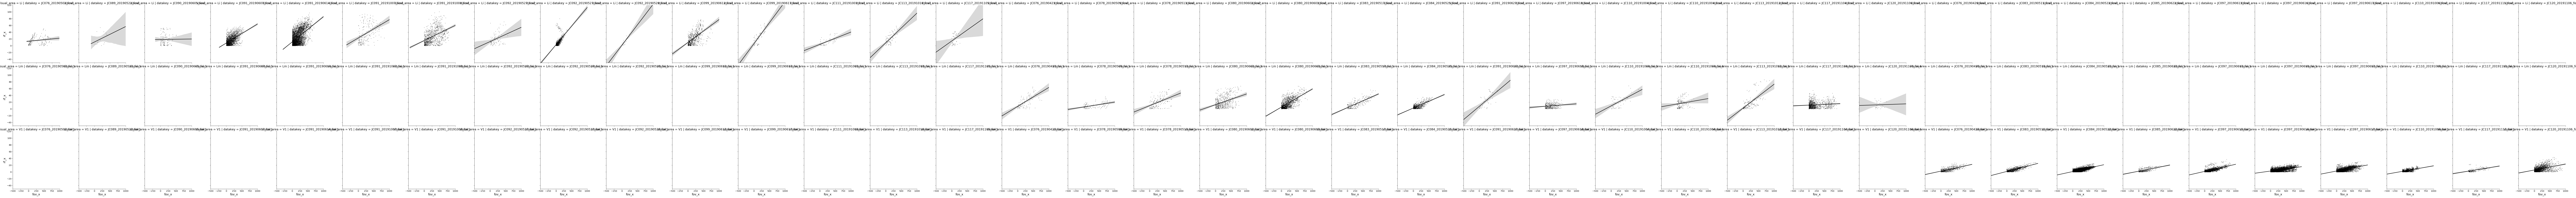

In [79]:
# Plot regression w/ CI
xvar = 'fov'
yvar = 'rf'


g = sns.lmplot('%s_x' % xvar, '%s_x' % yvar, data=diff_df, 
               row='visual_area', col='datakey', #col_wrap=6,
          scatter_kws={'s': 1,
                      'marker':'+',
                      'color': 'k'},
          line_kws={'color': 'k'})
g.fig.patch.set_alpha(1)
g.set(xlim=(-500, 1000), ylim=(-50, 120))


#### Plot PW stts for SPLITs

<IPython.core.display.Javascript object>


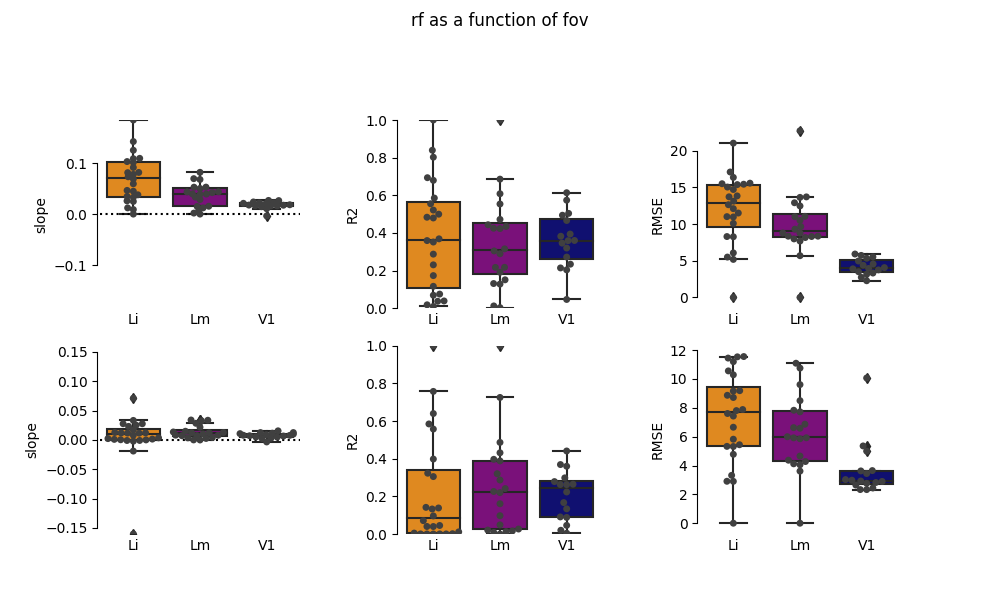

/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [95]:
fig, axes = pl.subplots(2, 3, figsize=(10,6))
fig.patch.set_alpha(1)

for ai, axn in enumerate(['xpos', 'ypos']):
    curr_pwstats = pwstats_split.groupby(['axis']).get_group(axn)

    ax1 = boxplot_visual_area(curr_pwstats, metric='slope', ax=axes[ai, 0], area_colors=area_colors)

    ax2 = boxplot_visual_area(curr_pwstats, metric='R2', ax=axes[ai, 1], area_colors=area_colors)

    ax3 = boxplot_visual_area(curr_pwstats, metric='RMSE', ax=axes[ai, 2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'split-axes_stats-regr-on-%s_bmo.svg' % indep_var))

In [96]:
def boxplot_visual_area(df, metric='slope', whichax=None, ax=None, area_colors=None):
    if ax is None:
        fig, ax = pl.subplots()
    if area_colors is None:
        visual_areas = sorted(df['visual_area'].unique())
        colors = sns.color_palette(palette='cubehelix', n_colors=len(visual_areas))
        area_colors = dict((k, col) for k, col in zip(visual_areas, colors))
        
    if whichax == None:
        metricname = metric
    else:
        metricname = '%s_%s' % (metric, whichax)

    df[metricname] = df[metricname].astype(float)
        
    sns.boxplot(x='visual_area', y=metricname, data=df, ax=ax, palette=area_colors)
    sns.swarmplot(x='visual_area', y=metricname, data=df, color=".25", ax=ax)
    ax.tick_params(axis='x', length=0)
    ax.set_xlabel('')       
    
    if metric in ['slope', 'pearsonr']:
        ax.axhline(y=0, linestyle=':', color='k')
        
    if metric == 'pearsonr':
        ax.set_ylim([-1, 1])
    elif metric in ['pearsonr-abs', 'R2']:
        ax.set_ylim([0, 1])
    elif metric == 'slope':
        maxv = df[metricname].abs().max()
        ax.set_ylim([-maxv, maxv])
    sns.despine(trim=True, offset=2, bottom=True, ax=ax)
    
    #ax.set_title('visual field distance (deg. vis. angle) per cortical distance (um)')
    return ax



#### PW dists, split:  Plot slope for Az and El on same 

In [97]:
axdf.groupby(['visual_area'])['slope'].apply(np.mean)

NameError: name 'axdf' is not defined

<IPython.core.display.Javascript object>


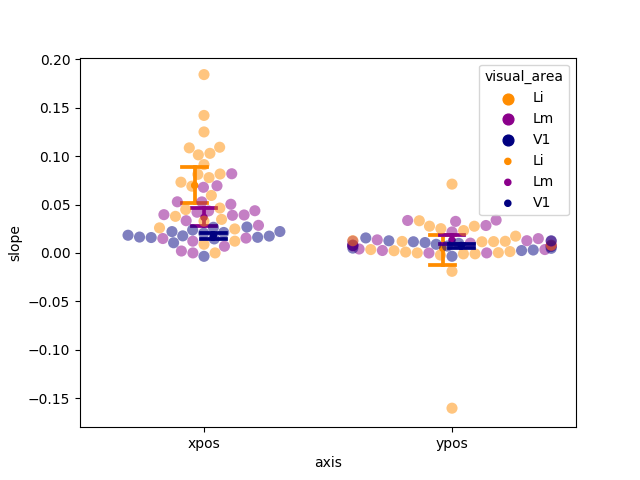

In [98]:
fig, ax = pl.subplots(1,1)
# dummy plots, just to get the Path objects
a = ax.scatter([0, 0],[0, 0], marker='s')
b = ax.scatter([0, 0],[0, 0], marker='o')
square_mk, = a.get_paths()
triangle_up_mk, = b.get_paths()
a.remove()
b.remove()

ax = sns.swarmplot(x="axis", y="slope", hue="visual_area",data=pwstats_split, 
                   palette=area_colors,size=8,ax=ax, dodge=False, alpha=0.5,facecolor='none')
N_hues = len(pd.unique(pwstats_split.visual_area))

c = ax.collections
for a in c[::N_hues]:
    a.set_paths([triangle_up_mk])
#update legend
ax.legend(c[-3:],pd.unique(pwstats_split.visual_area))


mvs = pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)

sns.pointplot(x='axis', y='slope', hue='visual_area', data=pwstats_split, ci=95, capsize=0.1,
             palette=area_colors, dodge=True, apha=0.7, markers='.', join=False)


In [185]:
pwstats_split.groupby(['axis', 'visual_area']).slope.apply(np.mean)


axis  visual_area
xpos  Li             0.063929
      Lm             0.045119
      V1             0.016610
ypos  Li             0.009870
      Lm             0.020191
      V1             0.009434
Name: slope, dtype: float64

In [99]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0   0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1    0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2    0.554981   14.701    JC089  xpos  JC089_20190522_FOV1_zoom2p0x   
3   0.0398027  11.2011    JC089  ypos  JC089_20190522_FOV1_zoom2p0x   
4  0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   

             fov intercept   session       slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502  0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502   0.0250456          Li  
2  FOV1_zoom2p0x   1.47137  20190522   0.0815022          Li  
3  FOV1_zoom2p0x   17.3205  20190522   -0.019012          Li  
4  FOV1_zoom2p0x   13.5166  20190605   0.0121294          Li

<IPython.core.display.Javascript object>


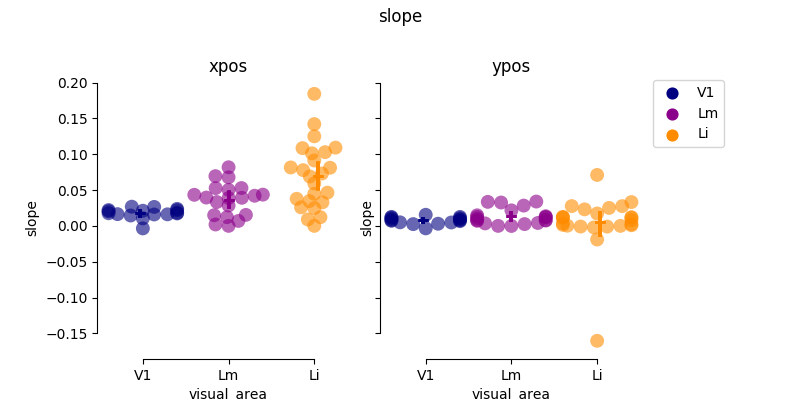

In [100]:

metric = 'slope'
fig, axes = pl.subplots(1, 2, sharex=True, sharey=True, figsize=(8,4))

for ax, axn in zip(axes.flat, ['xpos', 'ypos']):
    axdf = pwstats_split[pwstats_split['axis']==axn]
    g = sns.swarmplot(x='visual_area', y=metric, hue='visual_area', ax=ax,
                      palette=area_colors, data=axdf.sort_values(by='visual_area', ascending=False),
                     marker='o', facecolor='none', s=10,  alpha=0.6)

    for ai, visual_area in enumerate(visual_areas):
        mval =  axdf[axdf['visual_area']==visual_area][metric].mean()

       # ax.plot(ai, mval, color=area_colors[visual_area], marker='_', markersize=30)
        sns.pointplot(x='visual_area', y=metric, hue='visual_area', legend=False,
                     data=axdf.sort_values(by='visual_area', ascending=False),
                     ci=95, capsize=0., alpha=0.7,
                     palette=area_colors, dodge=True, markers='_', join=False, ax=ax)
    ax.set_title(axn)
    if axn == 'xpos':
        ax.legend_.remove()
    else:
        # Get the handles and labels. For this example it'll be 2 tuples
        # of length 4 each.
        handles, labels = ax.get_legend_handles_labels()

        # When creating the legend, only use the first two elements
        # to effectively remove the last two.
        l = pl.legend(handles[0:3], labels[0:3], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

sns.despine(trim=True, offset=2)
pl.subplots_adjust(wspace=0.1, right=0.8, top=0.8)
fig.suptitle(metric)

pl.savefig(os.path.join(pairwisedir, '%s_pw-dists_ax-v-el_bmo.svg' % metric))


In [141]:
pwstats_split.head()

R2     RMSE animalid  axis                       dataset  \
0    0.0179315   13.703    JC076  xpos  JC076_20190502_FOV1_zoom2p0x   
1     0.305154   9.1622    JC076  ypos  JC076_20190502_FOV1_zoom2p0x   
2   0.00923093  15.4884    JC090  xpos  JC090_20190605_FOV1_zoom2p0x   
3  0.000301296  7.80888    JC090  ypos  JC090_20190605_FOV1_zoom2p0x   
4      0.17312   12.629    JC091  xpos  JC091_20190602_FOV1_zoom2p0x   

             fov intercept   session        slope visual_area  
0  FOV1_zoom2p0x   15.0483  20190502   0.00892281          Li  
1  FOV1_zoom2p0x   5.17865  20190502    0.0250456          Li  
2  FOV1_zoom2p0x   13.5166  20190605    0.0121294          Li  
3  FOV1_zoom2p0x   7.84417  20190605 -0.000939114          Li  
4  FOV1_zoom2p0x   6.17185  20190602    0.0463447          Li

# Combine axes: PW distance regression for each dataset for each visual area

In [79]:
indep_var

'fov'

<IPython.core.display.Javascript object>


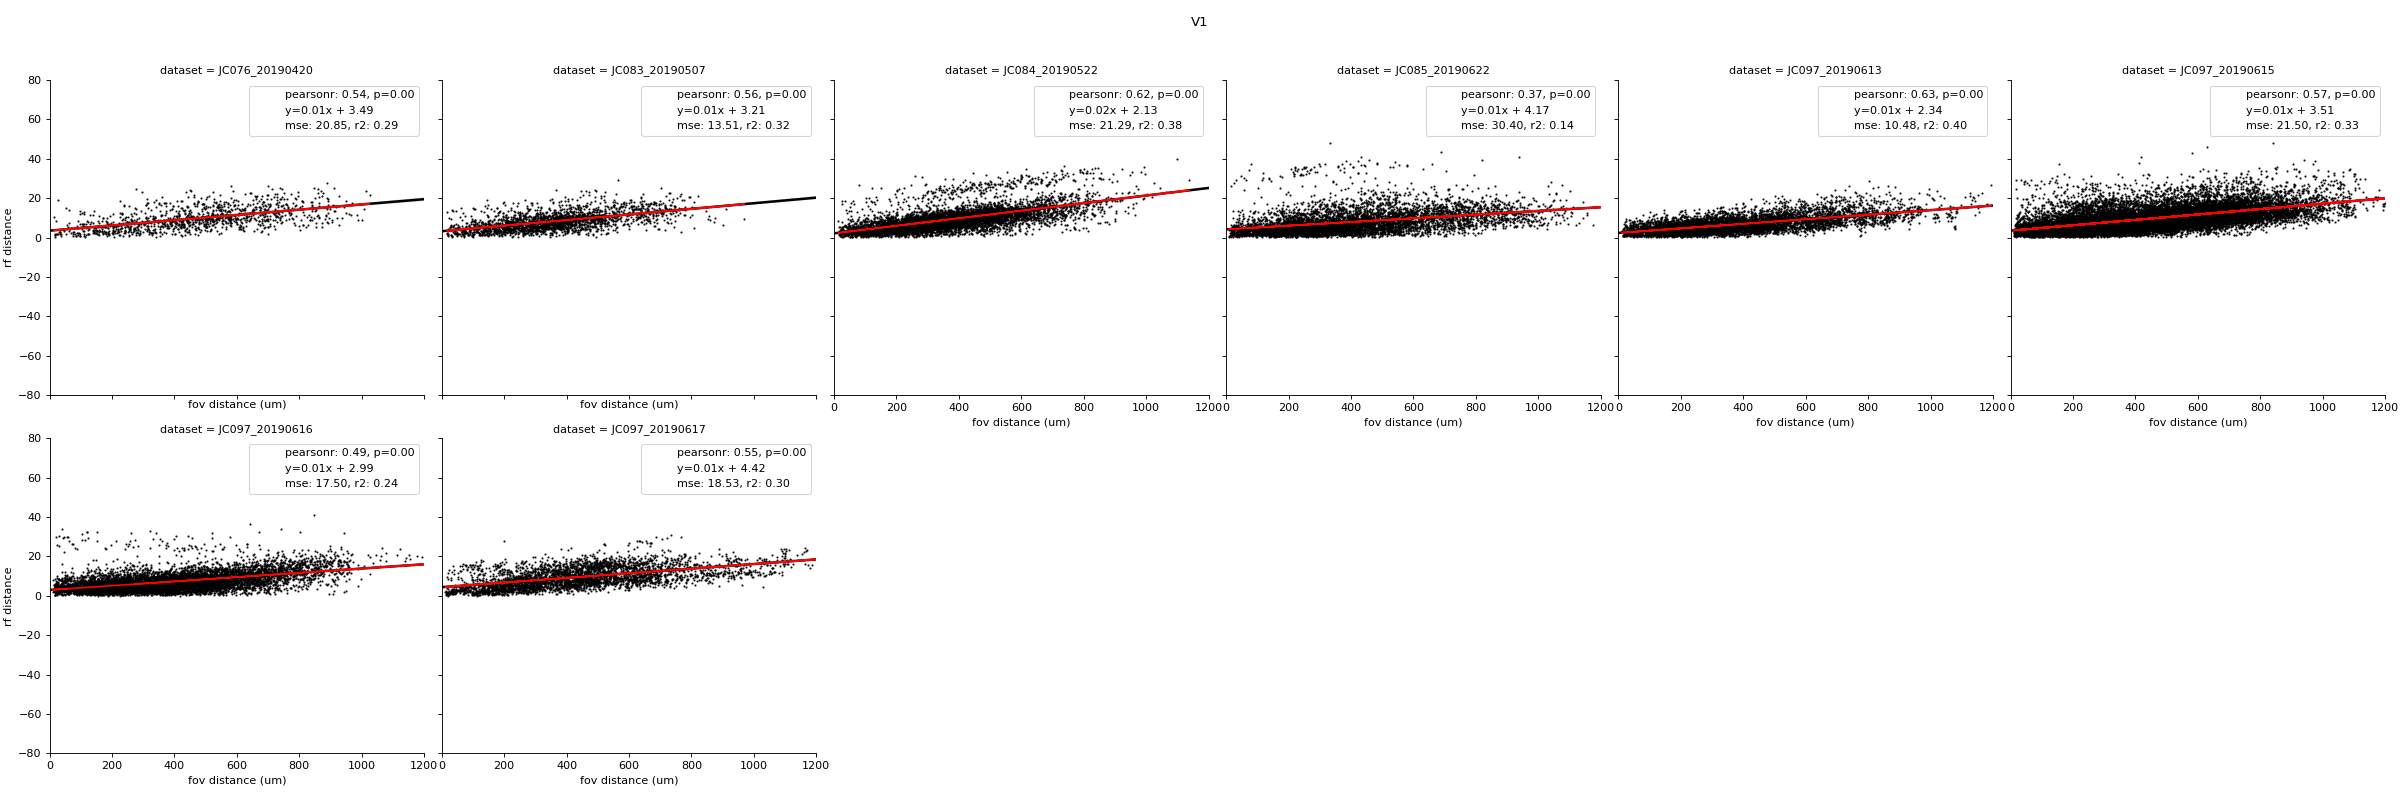

<IPython.core.display.Javascript object>


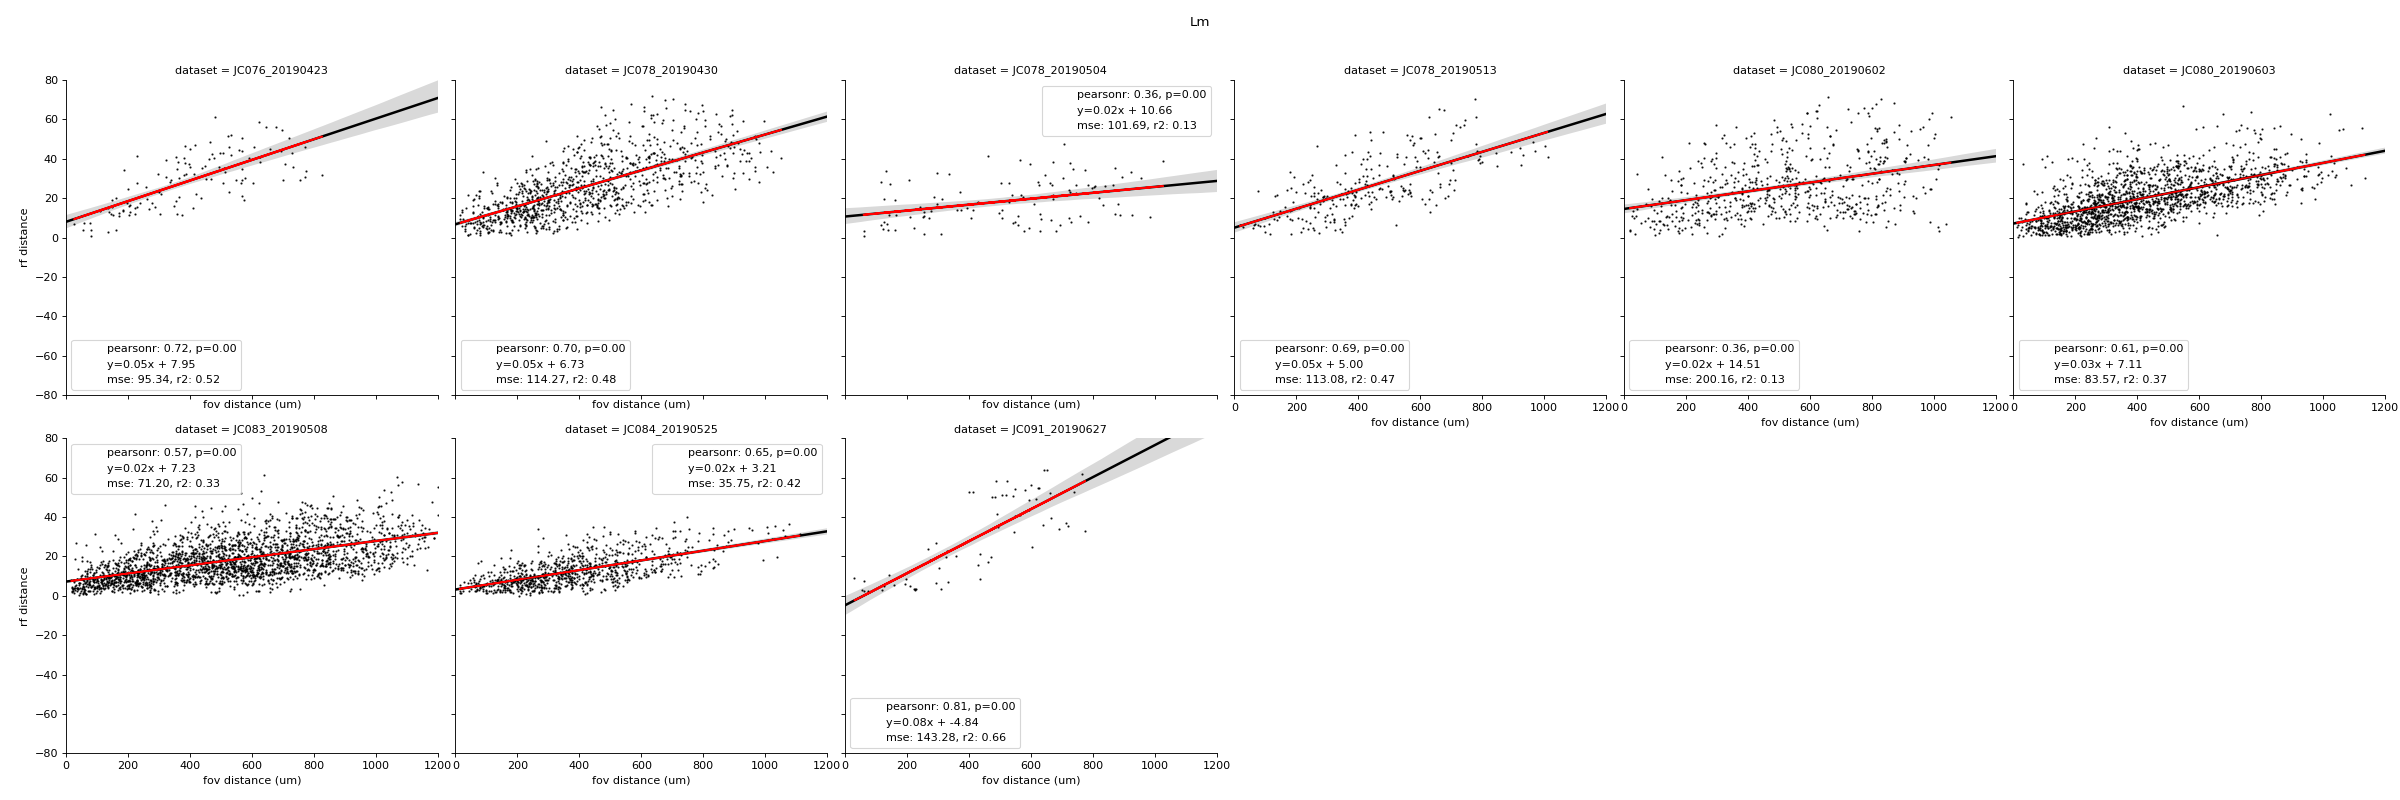

<IPython.core.display.Javascript object>


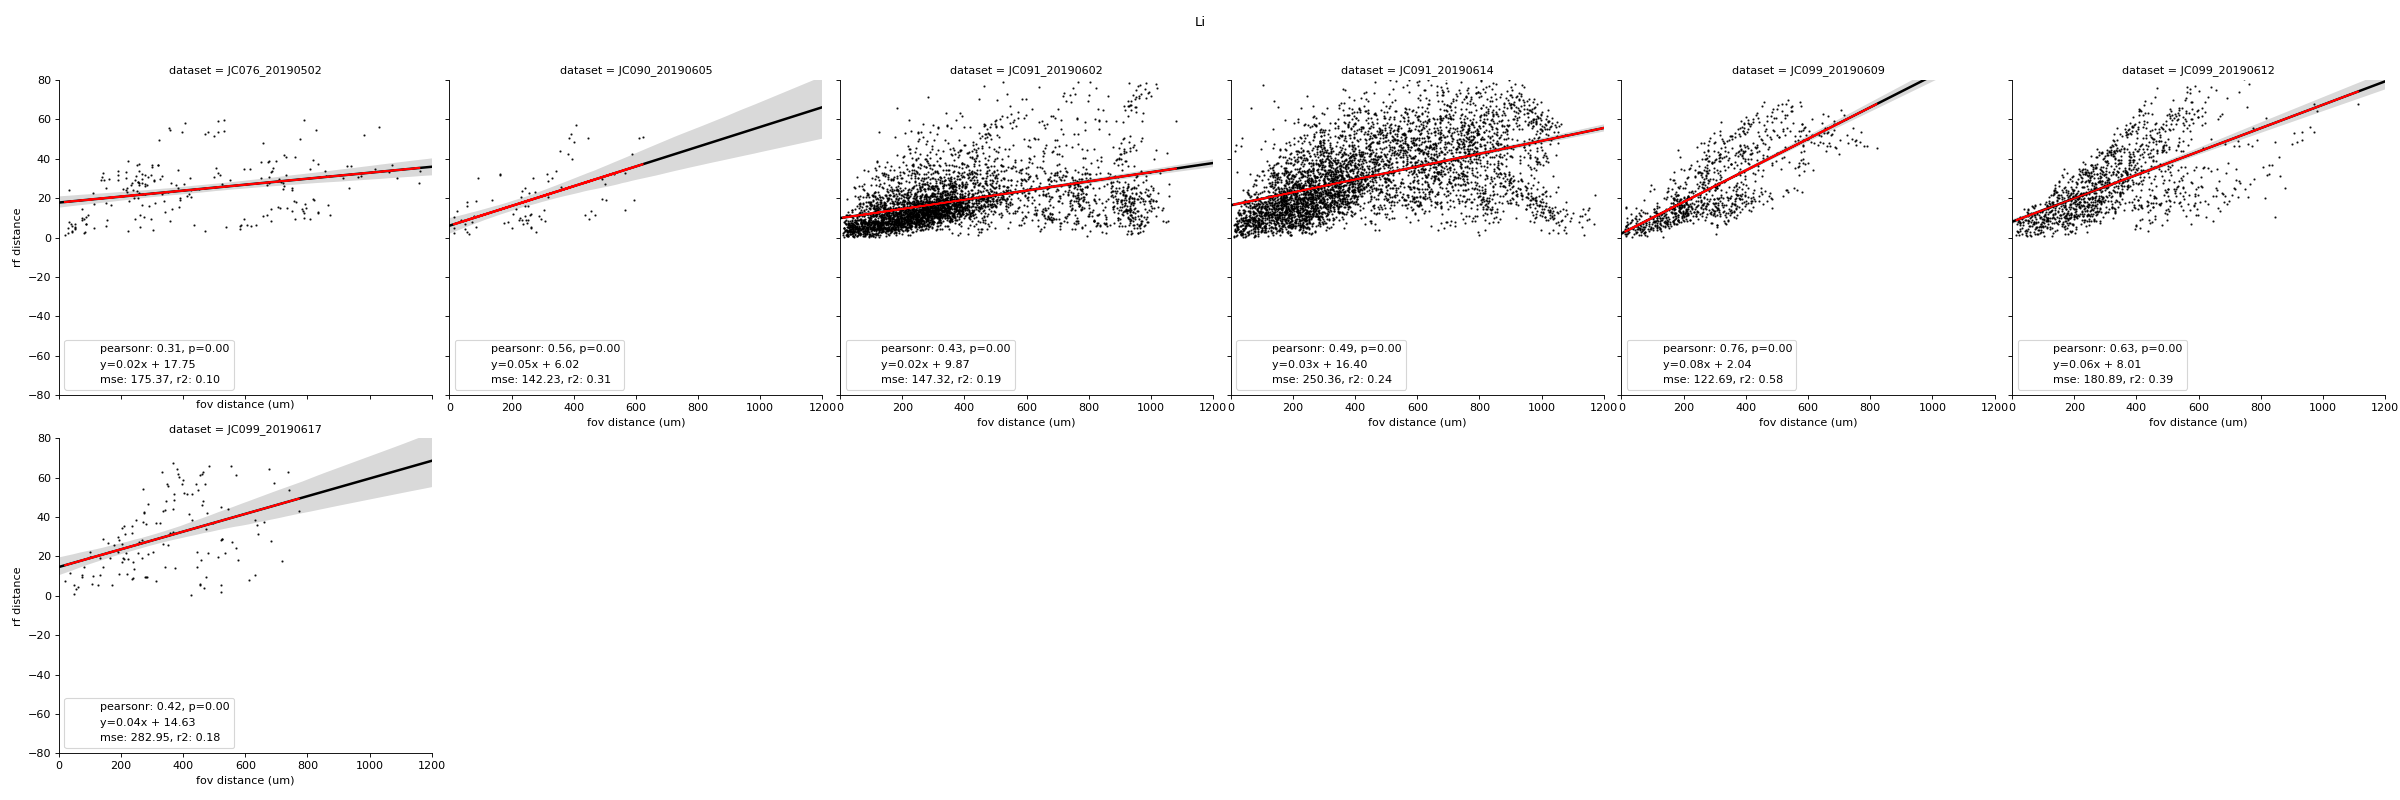

In [84]:
dep_var = 'rf' if indep_var=='fov' else 'fov'

xmin = 0 if indep_var=='fov' else -80
xmax = 1200 if indep_var=='fov' else 80
ymin = -80 if indep_var== 'fov' else 0
ymax = 80 if indep_var=='fov' else 1200


# regr_stats = []
for visual_area in ['V1', 'Lm', 'Li']:
    
    tmpd = pf[pf['visual_area']==visual_area]

    # Get all pairwise distances for each fov:
    tmpd_list = []
    for (animalid, session, fov), g in tmpd.groupby(['animalid', 'session', 'fov']):
        cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
        rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
        tmpd = pd.DataFrame({'%s distance' % indep_var: cdists,
                            '%s distance' % dep_var: rdists,
                            'dataset': ['%s_%s' % (animalid, session) for _ in range(len(cdists))]})
        tmpd_list.append(tmpd)
    pw = pd.concat(tmpd_list, axis=0)

    # Plot regression w/ CI
    g = sns.lmplot('%s distance' % indep_var, '%s distance' % dep_var, data=pw, col='dataset', col_wrap=6,
              scatter_kws={'s': 1,
                          'marker':'+',
                          'color': 'k'},
              line_kws={'color': 'k'})
    g.fig.patch.set_alpha(1)

    # Get linear fit and annotate plots
    for ax in g.fig.get_axes():
        curr_dset = ax.title.get_text().split(' ')[-1]
        xv = pw[pw['dataset']==curr_dset]['%s distance' % indep_var]
        yv = pw[pw['dataset']==curr_dset]['%s distance' % dep_var]
        #ax.set_ylim([0, 120])
        unit = 'um' if indep_var=='fov' else 'deg'
        ax.set_xlabel('%s distance (%s)' % (indep_var, unit))

        fitv, regr = fit_linear_regr(xv, yv, return_regr=True)
        ax.plot(xv, fitv, 'r')
        mse = skmetrics.mean_squared_error(yv, fitv)
        r2 = skmetrics.r2_score(yv, fitv)

        # Annotate
        p, r = spstats.pearsonr(xv, yv)
        stat_str = 'pearsonr: %.2f, p=%.2f' % (p, r)
        slope_str = 'y=%.2fx + %.2f' % (regr.coef_, regr.intercept_)
        regr_str = 'mse: %.2f, r2: %.2f' % (mse, r2)
        ax.plot(0, 0, alpha=0, label=stat_str)
        ax.plot(0, 0, alpha=0, label=slope_str)
        ax.plot(0, 0, alpha=0, label=regr_str)
        ax.legend()
        
        
        ax.set_xlim([xmin, xmax])
        ax.set_ylim([ymin, ymax])
        
#         regr_stats.append(pd.Series({'dataset': curr_dset,
#                                    'RMSE': np.sqrt(mse),
#                                    'slope': float(regr.coef_),
#                                    'intercept': float(regr.intercept_),
#                                    'R2': r2,
#                                     'visual_area': visual_area}))


    pl.subplots_adjust(top=0.9)
    g.fig.suptitle(visual_area)
    
    pl.savefig(os.path.join(curr_sessiondir, 'regr-on-%s_%s.png' % (visual_area, indep_var)))


In [94]:
# reginfo = pd.concat(regr_stats, axis=1).T
# reginfo.head()

R2     RMSE         dataset intercept       slope visual_area
0  0.291849   4.5666  JC076_20190420   3.49435   0.0133151          V1
1  0.110722  6.13418  JC076_20190501   6.32593  0.00917705          V1
2  0.317121  3.67584  JC083_20190507   3.21438   0.0141987          V1
3  0.177895  5.95603  JC083_20190510     5.859   0.0142868          V1
4   0.39773  3.88048  JC083_20190511   2.64958   0.0186305          V1

In [96]:
del reginfo

In [85]:

pwstats = []
for (visual_area, animalid, session, fov), g in pf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    # Get all pairwise distances for current fov:
    cdists = pdist(g[['xpos_%s' % indep_var, 'ypos_%s' % indep_var]])
    rdists = pdist(g[['xpos_%s' % dep_var, 'ypos_%s' % dep_var]])
    # Get linear fit:
    fitdist, regr = fit_linear_regr(cdists, rdists, return_regr=True)
    mse = skmetrics.mean_squared_error(rdists, fitdist)
    r2 = skmetrics.r2_score(rdists, fitdist)
    res = pd.Series({'visual_area': visual_area,
                         'animalid': animalid,
                         'session': session,
                         'fov': fov,
                         'RMSE': np.sqrt(mse),
                         'R2': r2,
                         'slope': float(regr.coef_),
                         'intercept': float(regr.intercept_),
                         'dataset': '_'.join([animalid, session, fov])})
    pwstats.append(res)

pwstats = pd.concat(pwstats, axis=1).T


In [86]:
pwstats.head()

R2     RMSE animalid                       dataset            fov  \
0  0.0953611  13.2428    JC076  JC076_20190502_FOV1_zoom2p0x  FOV1_zoom2p0x   
1    0.31371  11.9261    JC090  JC090_20190605_FOV1_zoom2p0x  FOV1_zoom2p0x   
2   0.186778  12.1375    JC091  JC091_20190602_FOV1_zoom2p0x  FOV1_zoom2p0x   
3   0.243542  15.8227    JC091  JC091_20190614_FOV1_zoom2p0x  FOV1_zoom2p0x   
4   0.584282  11.0767    JC099  JC099_20190609_FOV1_zoom2p0x  FOV1_zoom2p0x   

  intercept   session      slope visual_area  
0   17.7525  20190502  0.0151595          Li  
1   6.01845  20190605  0.0501515          Li  
2   9.86805  20190602  0.0233078          Li  
3   16.3973  20190614  0.0326908          Li  
4   2.04233  20190609  0.0800883          Li

<IPython.core.display.Javascript object>


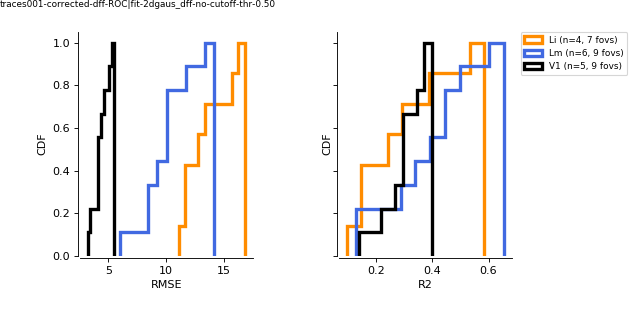

In [87]:
fig, axes = pl.subplots(1, 2, figsize=(8,4), sharey=True)
fig.patch.set_alpha(1)

for visual_area, tmpd in pwstats.groupby(['visual_area']):
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    values = tmpd['RMSE'].values.astype(float)
    #values = tmpd[['mse_el', 'mse_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
    
    ax = axes[0]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    ax.set_xlabel('RMSE')
    sns.despine(ax=ax, offset=2)
    ax.set_ylabel('CDF')
    
    
    values = tmpd['R2'].values.astype(float)
    #values = tmpd[['var_el', 'var_az']].values.ravel().astype(float)
    weights = np.ones_like(values)/float(len(values))
     
    ax = axes[1]
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    sns.despine(ax=ax, offset=2)
    ax.set_xlabel('R2')
    ax.set_ylabel('CDF')
    #ax.set_xticks([round(i, 1) for i in np.linspace(0, 1, 6)])

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.8, top=0.9, bottom=0.2, wspace=0.5)

label_figure(fig, data_identifier)
pl.savefig(os.path.join(pairwisedir, 'pairwise-distances_RMSE-R2_cdf_regr-on-%s.png' % indep_var))


# Look at slope / intercept

<IPython.core.display.Javascript object>


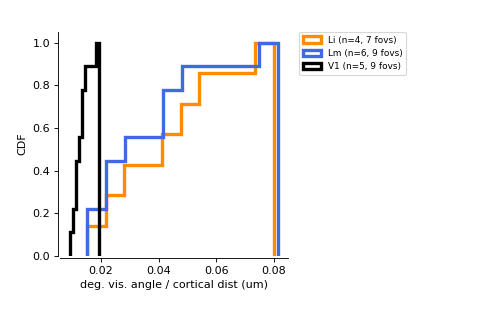

In [88]:
use_slope = True
fig, ax = pl.subplots(figsize=(6,4))

fig.patch.set_alpha(1)
for visual_area, tmpd in pwstats.groupby(['visual_area']):
    if use_slope:
        values = [s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'deg. vis. angle / cortical dist (um)'
        else:
            xlabel = 'cortical dist (um) / deg vis. angle'
    else:
        values = [1./s for s in tmpd['slope'].values.astype(float)]
        if indep_var == 'fov':
            xlabel = 'cortical dist (um) / deg vis. angle'
        else:
            xlabel = 'deg. vis. angle / cortical dist (um)'
    
    #dset_names = g['dataset'].unique()
    nrats = len(tmpd['animalid'].unique())
    nfovs = tmpd['fov'].count()
    
    weights = np.ones_like(values)/float(len(values))
    ax.hist(values, 
            cumulative=True,
            label='%s (n=%i, %i fovs)' % (visual_area, nrats, nfovs),
            color=area_colors[visual_area],
            histtype='step', alpha=1.0, lw=3,
            normed=0, weights=weights)
    #ax.set_xticks([round(v, 1) for v in np.linspace(0, .1, 8)])
    #ax.set_xticklabels([round(v, 2) for v in np.linspace(0, .1, 8)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel('CDF')
    sns.despine(trim=False, offset=2, ax=ax)

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=8)
pl.subplots_adjust(right=0.6, top=0.9, bottom=0.2, wspace=0.5)

pl.savefig(os.path.join(pairwisedir, 'slopes_regr-on-%s_cdf.png' % indep_var))

<IPython.core.display.Javascript object>


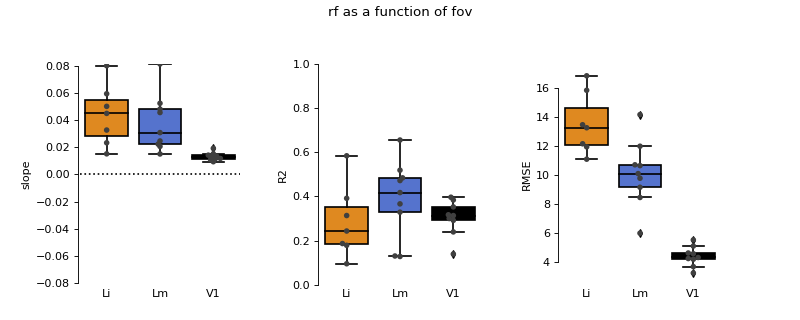

In [89]:
fig, axes = pl.subplots(1, 3, figsize=(10,4))
fig.patch.set_alpha(1)

ax1 = boxplot_visual_area(pwstats, metric='slope', ax=axes[0], area_colors=area_colors)

ax2 = boxplot_visual_area(pwstats, metric='R2', ax=axes[1], area_colors=area_colors)

ax3 = boxplot_visual_area(pwstats, metric='RMSE', ax=axes[2], area_colors=area_colors)

pl.subplots_adjust(wspace=0.5, top=0.8, left=0.1)

fig.suptitle('%s as a function of %s' % (dep_var, indep_var))

pl.savefig(os.path.join(pairwisedir, 'stats-regr-on-%s.png' % indep_var))

In [113]:
posdf.head()

index animalid            fov   session visual_area    xpos_fov    xpos_rf  \
0      5    JC076  FOV1_zoom2p0x  20190420          V1   41.969973  45.590696   
1      7    JC076  FOV1_zoom2p0x  20190420          V1  267.081644  34.002847   
2     24    JC076  FOV1_zoom2p0x  20190420          V1  129.725370  40.360602   
3     25    JC076  FOV1_zoom2p0x  20190420          V1  120.186740  43.581691   
4     26    JC076  FOV1_zoom2p0x  20190420          V1  146.894904  43.078912   

     ypos_fov   ypos_rf  
0  273.349886  5.655262  
1  125.092321  1.460737  
2  356.744767  4.182264  
3  403.075256  2.775072  
4  379.910012  2.955575

<IPython.core.display.Javascript object>


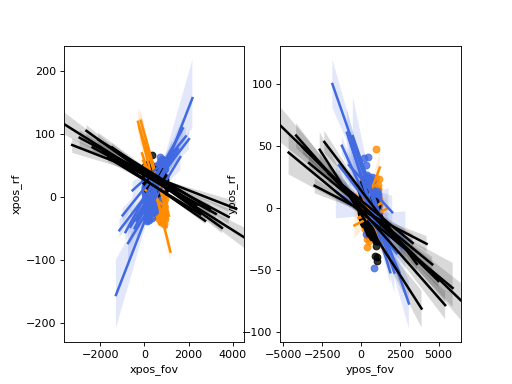

In [90]:
fig, axes = pl.subplots(1, 2)


for (visual_area, animalid, session, fov), tmpd in posdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.regplot('xpos_fov', 'xpos_rf', data=tmpd, ax=axes[0], color=area_colors[visual_area])
    sns.regplot('ypos_fov', 'ypos_rf', data=tmpd, ax=axes[1], color=area_colors[visual_area])


# Plot Center of mass for each FOV

In [101]:
df.head()

r2    sigma_x    sigma_y     theta         x0         y0 animalid  \
13  0.592816  13.408074  11.469334 -0.288729  12.200497   0.748017    JC089   
14  0.554771  19.490870  10.009762 -0.994947 -51.552794  10.413053    JC089   
15  0.512692  11.433837   5.652660 -0.673435   4.479900   0.366059    JC089   
16  0.571984  15.485803   9.977350  0.513668   8.736586   1.810410    JC089   
17  0.800984  13.283970  14.656829 -0.968406   4.725769  11.074534    JC089   

    cell              datakey experiment   session visual_area   avg_size  \
13   113  20190522_JC089_fov1      rfs10  20190522          Li  12.438704   
14    11  20190522_JC089_fov1      rfs10  20190522          Li  14.750316   
15    80  20190522_JC089_fov1      rfs10  20190522          Li   8.543248   
16   145  20190522_JC089_fov1      rfs10  20190522          Li  12.731577   
17   116  20190522_JC089_fov1      rfs10  20190522          Li  13.970399   

    datakey_ix        fx        fy  
13           1  6.426534  1.908865  
14           1  5.306854  8.173787  
15           1  4.468822  3.565500  
16           1  6.743666  3.804668  
17           1  4.152378  6.038495

In [104]:
CoMs = {}
screeninfo = {}
for (visual_area, animalid, session, fovnum), tmpd in df.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
    S = util.Session(animalid, session, 'FOV%i_zoom2p0x' % fovnum)
    xpos, ypos = S.get_stimulus_coordinates()
    CoMs['%s_%s' % (animalid, session)] = (xpos, ypos) #[(xpos, ypos) for _ in range(tmpd.shape[0])])
    screenleft, screenright = S.screen['linminW'], S.screen['linmaxW']
    screenbottom, screentop = S.screen['linminH'], S.screen['linmaxH']
    screenaspect = S.screen['resolution'][0] / S.screen['resolution'][1]
    screeninfo['%s_%s' % (animalid, session)] = (screenleft, screenright, screenbottom, screentop, screenaspect) #for _ in range(tmpd.shape[0])])
    

[JC089] 20190522 - FOV1_zoom2p0x:  Getting anatomicals...
No anatomicals for current session: (JC089 | 20190522 | FOV1_zoom2p0x)
... Getting screen info
getting screen info
checking res...
[JC089|20190522] No experiment exists for: blobs
[JC089|20190522|FOV1_zoom2p0x] creating gratings object
Getting stimulus info for: combined_gratings_static


AssertionError: [gratings] more than 1 xpos found! []

In [204]:


rfdf['CoM-x'] = [CoMs['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

rfdf['CoM-y'] = [CoMs['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenleft'] = [screeninfo['%s_%s' % (animalid, session)][0] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenright'] = [screeninfo['%s_%s' % (animalid, session)][1] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenbottom'] = [screeninfo['%s_%s' % (animalid, session)][2] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screentop'] = [screeninfo['%s_%s' % (animalid, session)][3] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]
rfdf['screenaspect'] = [screeninfo['%s_%s' % (animalid, session)][4] for animalid, session in zip(rfdf['animalid'].values, rfdf['session'].values)]

In [205]:
rfdf[((rfdf['animalid']=='JC084') & (rfdf['session']=='20190522'))]

r2    sigma_x    sigma_y     theta         x0         y0   cell  \
0    0.734225  15.872766  23.564779  1.533098  24.776422 -11.469018    0.0   
1    0.520136  16.516020  19.051182 -0.523212  32.432005 -11.544950    2.0   
2    0.552829  18.949260  27.004408 -1.426131  17.836423 -12.234272    5.0   
3    0.852096  23.878438  19.566025 -0.027895  24.116823 -11.728018    9.0   
4    0.869807  21.945404  16.465211  0.250786  21.851019 -11.102363   11.0   
5    0.749326  24.060205  17.826767 -0.540785  21.079350 -12.622418   12.0   
6    0.855683  30.551514  22.742899 -0.194002  24.359459 -15.700910   17.0   
7    0.696656  27.990076  23.843953  0.069130  25.972457 -13.935280   18.0   
8    0.768487  21.792108  20.778926  0.133244  24.595777 -15.828255   19.0   
9    0.647991  19.231749  23.597969  7.482864  24.647061 -14.644582   20.0   
10   0.664964  28.485420  23.327092 -0.165733  22.522499 -13.689643   21.0   
11   0.697408  37.220701  20.067509 -0.538142  25.617105 -14.165844   23.0   
12   0.830778  28.052161  22.851207  0.019171  23.959988 -18.060165   25.0   
13   0.659888  24.684523  22.871740 -0.110131  25.477272 -14.224848   26.0   
14   0.706372  32.309309  21.921249 -3.626894  24.790675 -15.134649   27.0   
15   0.771317   6.238730   6.857521  2.065690  19.994226 -19.770466   29.0   
16   0.528987  13.406842  11.629828 -2.447291  27.486044 -15.949036   30.0   
17   0.838610  18.920871  15.368178 -6.821364  25.340041 -17.589140   33.0   
18   0.758682  25.043465  28.017584  0.173640  26.432311 -20.467824   35.0   
19   0.842691  17.751149  33.932036  0.535572  30.602510 -26.987631   36.0   
20   0.623137  39.765831  24.771200 -0.669511  22.286065 -18.509528   41.0   
21   0.618670  35.668650  19.654706 -0.137295  20.236856 -13.920210   43.0   
22   0.580811  15.462046  12.018522  1.919947  21.389652 -17.079508   46.0   
23   0.802064  27.752021  20.591647 -0.668535  20.685405 -13.793877   51.0   
24   0.871361  14.736783  11.827486 -0.605707  20.827247 -19.105224   55.0   
25   0.922144  17.177681  26.224431  0.493811  21.744589 -22.958313   56.0   
26   0.871618  16.521106  23.569554  0.764062  22.413474 -18.922926   57.0   
27   0.891020  14.663139  17.637268  1.201600  24.708676 -18.084358   61.0   
28   0.686160  21.183891  16.435022 -0.022699  20.866747 -21.480730   63.0   
29   0.844889  22.705430  32.684764  0.442448  23.979186 -21.983852   65.0   
..        ...        ...        ...       ...        ...        ...    ...   
81   0.721882  20.436226  27.460882 -0.427208  11.284117 -23.986294  171.0   
82   0.635870  25.878303  24.444987 -0.434986  10.510104 -20.072448  174.0   
83   0.813350  22.483890  18.742877  0.397909  11.166434 -18.448552  175.0   
84   0.865164  26.305847  31.387653  0.166666  11.483976 -18.466111  177.0   
85   0.849957  18.340392  30.809925  0.294362  15.497146 -21.477660  179.0   
86   0.693269  26.096302  35.645822  0.755536  16.707170 -20.983488  184.0   
87   0.781412  27.342184  39.406041  0.147644  12.491562 -30.599855  188.0   
88   0.582609  20.290799  24.464417 -0.417452   9.750868 -24.421227  189.0   
89   0.782352  20.881153  25.918258  0.259672  12.556678 -18.171527  190.0   
90   0.835715  14.808048  10.128542  0.177550  14.062034 -13.210156  191.0   
91   0.794471  18.984261  22.412270  0.314406  14.864463 -15.403845  193.0   
92   0.562086  32.455780  21.475909  0.154162  23.113591 -11.583298  194.0   
93   0.813154  27.714355  20.883445 -0.044016  16.923544  -9.058432  203.0   
94   0.606997  29.982173  21.429867  2.886234  13.142431 -11.571851  205.0   
95   0.782076  18.206397  14.606948 -3.506632  14.061718 -10.883947  210.0   
96   0.620140  22.385888  14.165443 -0.340382  14.972889 -10.682200  212.0   
97   0.530217  27.988678  21.714117  0.250591  15.421748 -13.415667  215.0   
98   0.750720  32.446550  29.802162 -0.214508  15.885883 -13.517998  216.0   
99   0.524750  32.493424  14.750089 -0.098812   7.807519  -8.524383  223.0   
100  0.700816  24.475980  21.8589

In [173]:
assert len(rfdf['screenleft'].unique())==1
assert len(rfdf['screenright'].unique())==1
assert len(rfdf['screentop'].unique())==1
assert len(rfdf['screenbottom'].unique())==1

In [170]:
screenleft = float(rfdf['screenleft'].unique())
screenright = float(rfdf['screenright'].unique())
screenbottom = float(rfdf['screenbottom'].unique())
screentop = float(rfdf['screentop'].unique())

In [247]:
all_cell_counts = rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']).count()['r2'].values
max_ncells = all_cell_counts.max()

ncells_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in all_cell_counts]
#ncells_alphas

[0.09502262443438914,
 0.058823529411764705,
 0.6244343891402715,
 0.2171945701357466,
 0.33031674208144796,
 0.43891402714932126,
 0.19909502262443438,
 0.23076923076923078,
 0.07692307692307693,
 0.07239819004524888,
 0.4117647058823529,
 0.20361990950226244,
 0.06787330316742081,
 0.06334841628959276,
 0.10407239819004525,
 0.14027149321266968,
 0.16289592760180996,
 0.26244343891402716,
 0.3167420814479638,
 0.248868778280543,
 0.09954751131221719,
 0.19004524886877827,
 0.05429864253393665,
 0.2171945701357466,
 0.07692307692307693,
 0.2986425339366516,
 0.17194570135746606,
 0.2171945701357466,
 0.502262443438914,
 0.8823529411764706,
 0.8190045248868778,
 0.6470588235294118,
 0.5610859728506787,
 1.0,
 0.38461538461538464]

In [250]:
import matplotlib.colors as mplc

In [255]:
[mplc.to_rgba(area_colors[visual_area], alpha=c) for c in cell_alphas]

[(1.0, 0.5490196078431373, 0.0, 0.09502262443438914),
 (1.0, 0.5490196078431373, 0.0, 0.058823529411764705),
 (1.0, 0.5490196078431373, 0.0, 0.6244343891402715),
 (1.0, 0.5490196078431373, 0.0, 0.2171945701357466),
 (1.0, 0.5490196078431373, 0.0, 0.33031674208144796),
 (1.0, 0.5490196078431373, 0.0, 0.43891402714932126),
 (1.0, 0.5490196078431373, 0.0, 0.19909502262443438),
 (1.0, 0.5490196078431373, 0.0, 0.23076923076923078),
 (1.0, 0.5490196078431373, 0.0, 0.07692307692307693)]

<IPython.core.display.Javascript object>


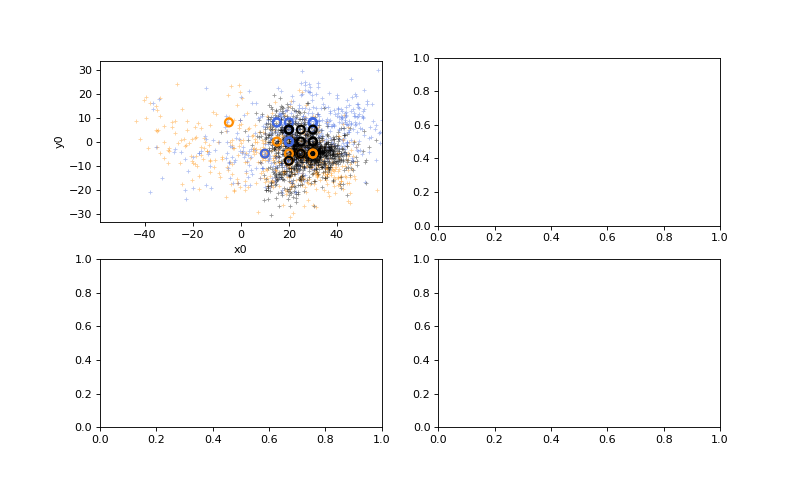

In [303]:
n_cells = []

fig, axes = pl.subplots(2, 2, figsize=(10,6))
ax = axes[0,0]
for (visual_area, animalid, session, fov), tmpd in rfdf.groupby(['visual_area', 'animalid', 'session', 'fov']):
    sns.scatterplot('x0', 'y0', data=tmpd, ax=ax, color=area_colors[visual_area],
                   s=10, marker='+', alpha=0.4, edgecolor=area_colors[visual_area])
    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)

    n_cells.append(tmpd.shape[0])

ax = axes[0,0]
for visual_area, tmpd in rfdf.groupby(['visual_area']):
    xcoms = [float(g['CoM-x'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ycoms = [float(g['CoM-y'].unique()) for k, g in tmpd.groupby(['animalid', 'session', 'fov'])]
    ncells = np.array([g.shape[0] for k, g in tmpd.groupby(['animalid', 'session', 'fov'])])
    cell_alphas = [convert_range(float(n), newmin=0, newmax=1, oldmin=0, oldmax=max_ncells) for n in ncells]

    rgba_colors = [mplc.to_rgba(area_colors[visual_area], alpha=c/4.) for c in cell_alphas]
    
    ax.scatter(xcoms, ycoms, s=50, lw=2, edgecolors=area_colors[visual_area], alpha=1, facecolor='none') #c=rgba_colors, 
    #ax.scatter(xcoms, ycoms, s=ncells, c=rgba_colors)

    ax.set_xlim([screenleft, screenright])
    ax.set_ylim([screenbottom, screentop])
    ax.set_aspect(screenaspect)


In [232]:
ncells

[48, 17, 66, 38, 48, 111, 195, 181, 143, 124, 221, 85]